# 👾 PixelCNN from scratch

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset from scratch

The code has been adapted from the excellent [PixelCNN tutorial](https://keras.io/examples/generative/pixelcnn/) created by ADMoreau, available on the Keras website.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))
from notebooks.utils import display

## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

In [4]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

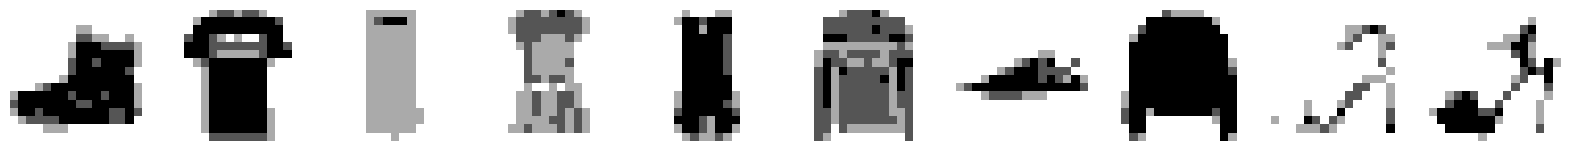

In [5]:
# Show some items of clothing from the training set
display(input_data)

## 2. Build the PixelCNN

In [6]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [7]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [8]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d (MaskedConv2D  (None, 16, 16, 128)      6400      
 )                                                               
                                                                 
 residual_block (ResidualBlo  (None, 16, 16, 128)      53504     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                       

## 3. Train the PixelCNN <a name="train"></a>

In [9]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [10]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

Epoch 1/150
469/469 [==============================] - ETA: 0s - loss: 0.4880 
Saved to ./output/generated_img_000.png


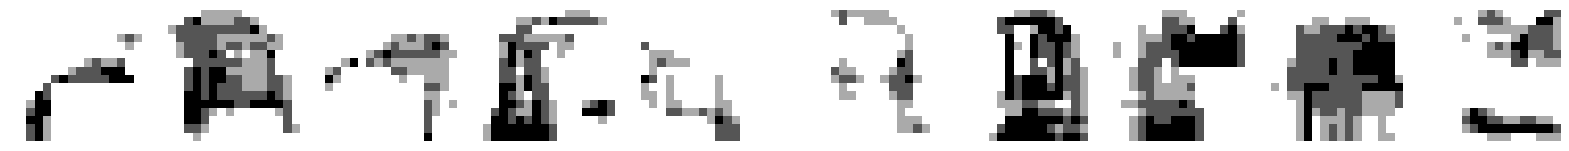

469/469 [==============================] - 34s 61ms/step - loss: 0.4880
Epoch 2/150
468/469 [============================>.] - ETA: 0s - loss: 0.3979  
Saved to ./output/generated_img_001.png


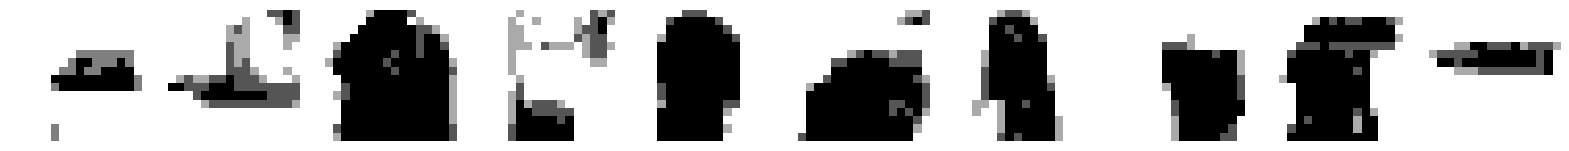

469/469 [==============================] - 28s 59ms/step - loss: 0.3978
Epoch 3/150
468/469 [============================>.] - ETA: 0s - loss: 0.3852  
Saved to ./output/generated_img_002.png


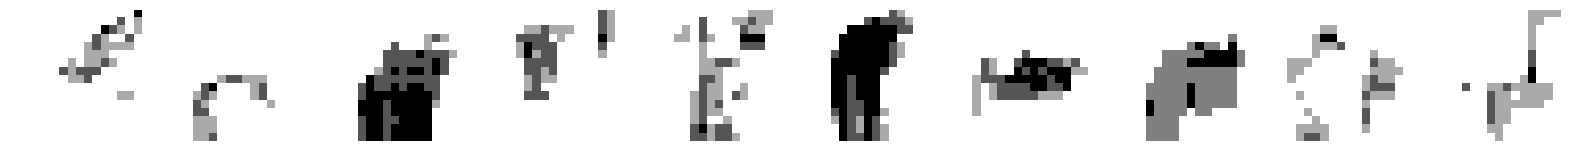

469/469 [==============================] - 28s 60ms/step - loss: 0.3852
Epoch 4/150
468/469 [============================>.] - ETA: 0s - loss: 0.3791  
Saved to ./output/generated_img_003.png


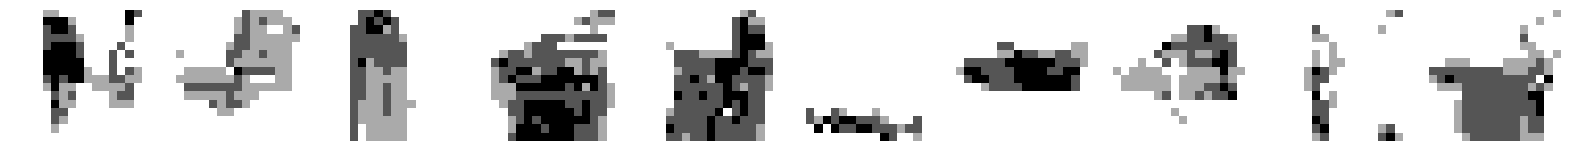

469/469 [==============================] - 28s 59ms/step - loss: 0.3791
Epoch 5/150
469/469 [==============================] - ETA: 0s - loss: 0.3747  
Saved to ./output/generated_img_004.png


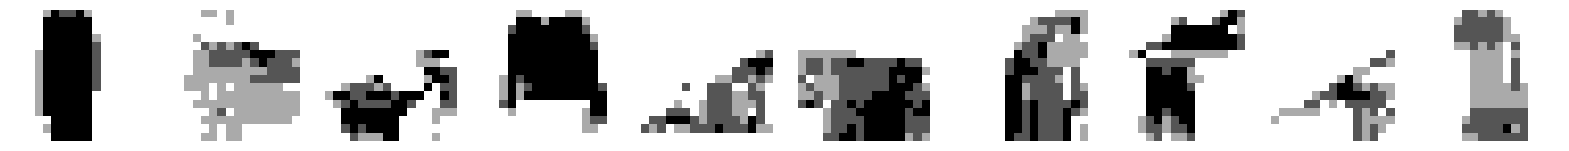

469/469 [==============================] - 28s 59ms/step - loss: 0.3747
Epoch 6/150
469/469 [==============================] - ETA: 0s - loss: 0.3714  
Saved to ./output/generated_img_005.png


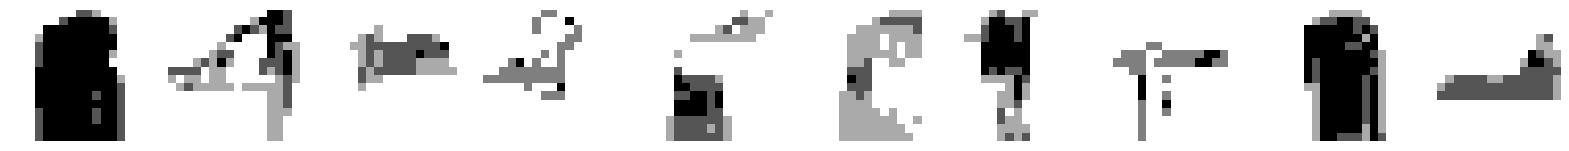

469/469 [==============================] - 28s 60ms/step - loss: 0.3714
Epoch 7/150
468/469 [============================>.] - ETA: 0s - loss: 0.3684  
Saved to ./output/generated_img_006.png


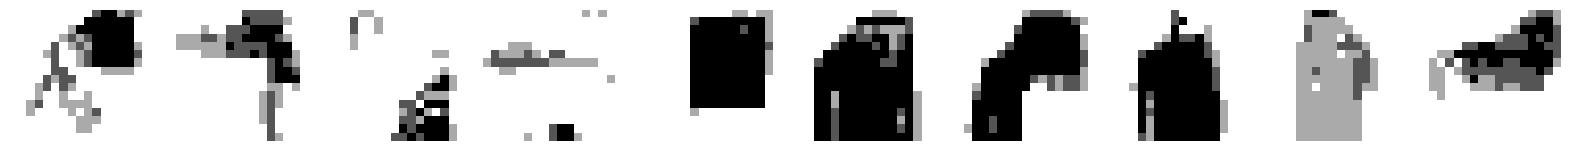

469/469 [==============================] - 28s 59ms/step - loss: 0.3683
Epoch 8/150
468/469 [============================>.] - ETA: 0s - loss: 0.3657  
Saved to ./output/generated_img_007.png


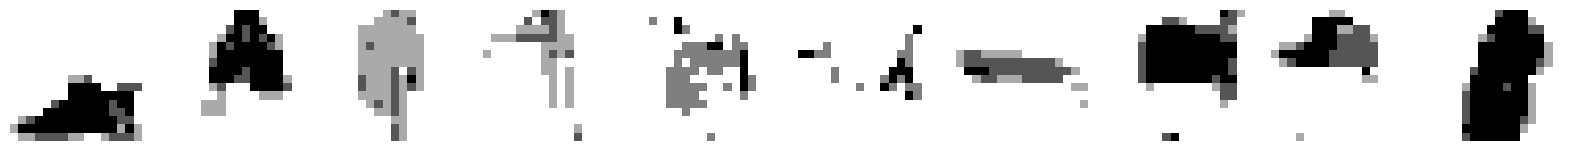

469/469 [==============================] - 28s 59ms/step - loss: 0.3657
Epoch 9/150
468/469 [============================>.] - ETA: 0s - loss: 0.3629  
Saved to ./output/generated_img_008.png


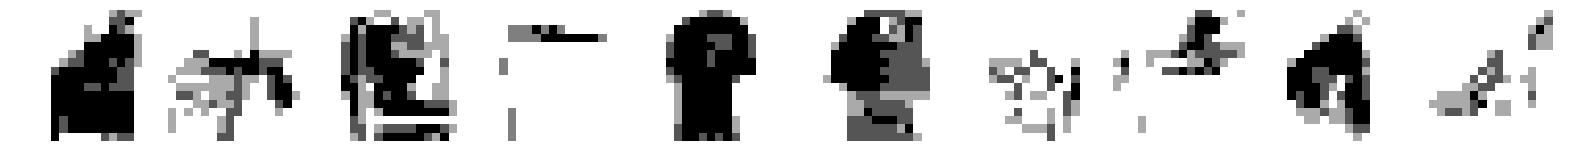

469/469 [==============================] - 28s 59ms/step - loss: 0.3629
Epoch 10/150
469/469 [==============================] - ETA: 0s - loss: 0.3605  
Saved to ./output/generated_img_009.png


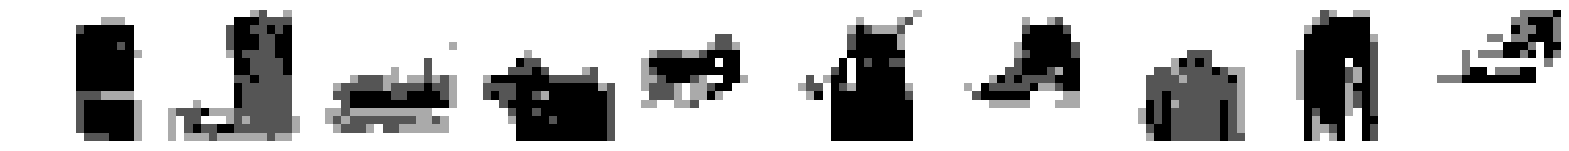

469/469 [==============================] - 28s 59ms/step - loss: 0.3605
Epoch 11/150
469/469 [==============================] - ETA: 0s - loss: 0.3584  
Saved to ./output/generated_img_010.png


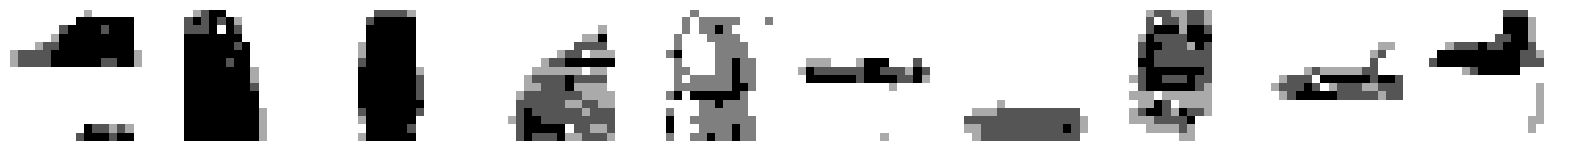

469/469 [==============================] - 28s 60ms/step - loss: 0.3584
Epoch 12/150
468/469 [============================>.] - ETA: 0s - loss: 0.3566  
Saved to ./output/generated_img_011.png


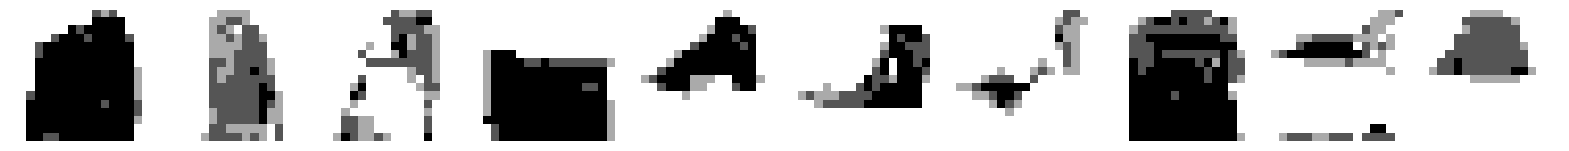

469/469 [==============================] - 30s 63ms/step - loss: 0.3566
Epoch 13/150
467/469 [============================>.] - ETA: 0s - loss: 0.3553  
Saved to ./output/generated_img_012.png


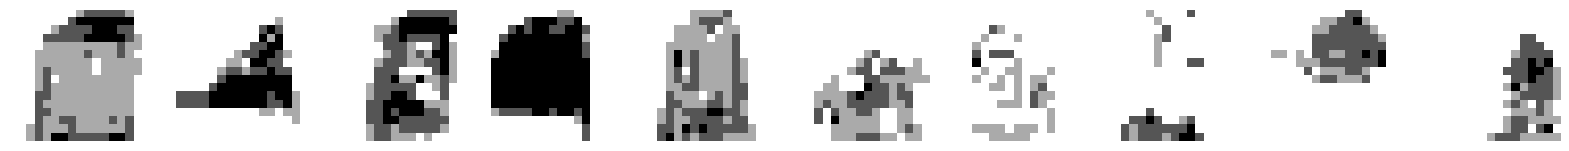

469/469 [==============================] - 29s 61ms/step - loss: 0.3553
Epoch 14/150
469/469 [==============================] - ETA: 0s - loss: 0.3537  
Saved to ./output/generated_img_013.png


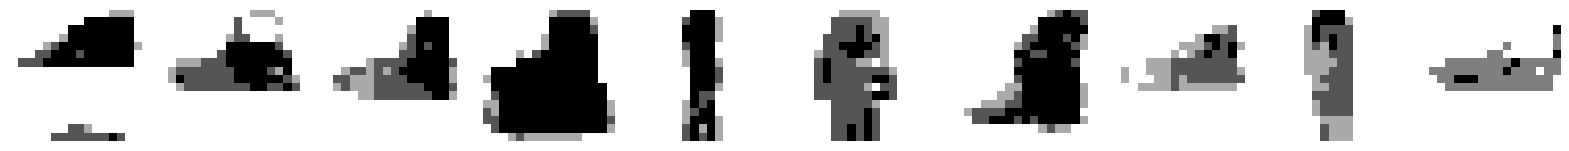

469/469 [==============================] - 30s 64ms/step - loss: 0.3537
Epoch 15/150
468/469 [============================>.] - ETA: 0s - loss: 0.3525  
Saved to ./output/generated_img_014.png


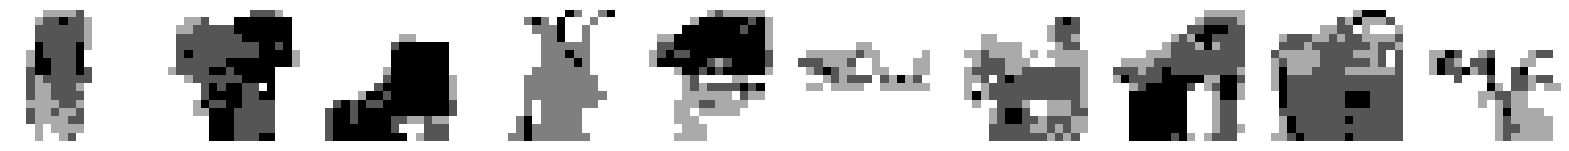

469/469 [==============================] - 29s 62ms/step - loss: 0.3525
Epoch 16/150
468/469 [============================>.] - ETA: 0s - loss: 0.3515  
Saved to ./output/generated_img_015.png


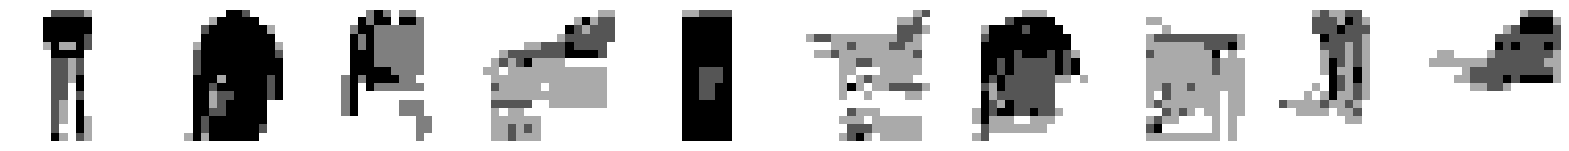

469/469 [==============================] - 30s 63ms/step - loss: 0.3515
Epoch 17/150
468/469 [============================>.] - ETA: 0s - loss: 0.3502  
Saved to ./output/generated_img_016.png


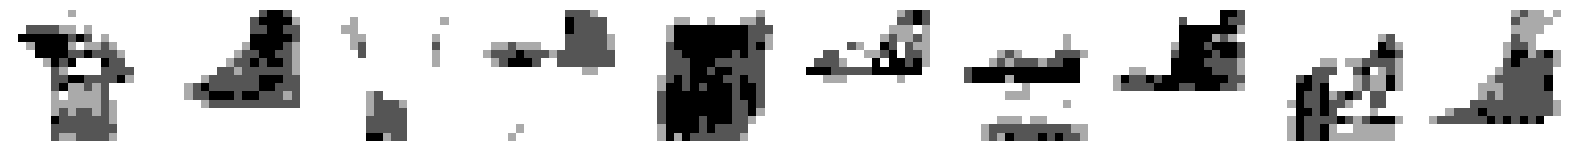

469/469 [==============================] - 30s 63ms/step - loss: 0.3501
Epoch 18/150
468/469 [============================>.] - ETA: 0s - loss: 0.3496  
Saved to ./output/generated_img_017.png


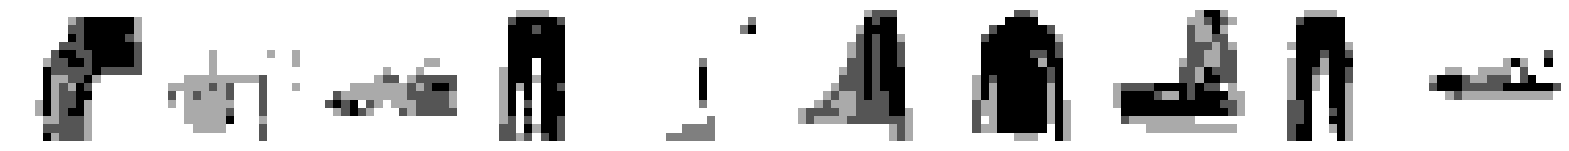

469/469 [==============================] - 29s 62ms/step - loss: 0.3495
Epoch 19/150
468/469 [============================>.] - ETA: 0s - loss: 0.3483  
Saved to ./output/generated_img_018.png


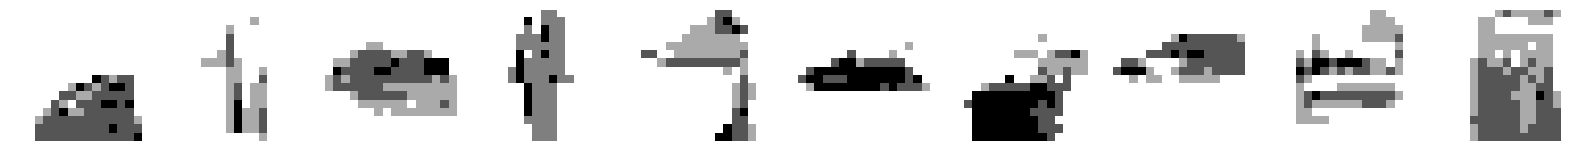

469/469 [==============================] - 30s 64ms/step - loss: 0.3483
Epoch 20/150
467/469 [============================>.] - ETA: 0s - loss: 0.3478  
Saved to ./output/generated_img_019.png


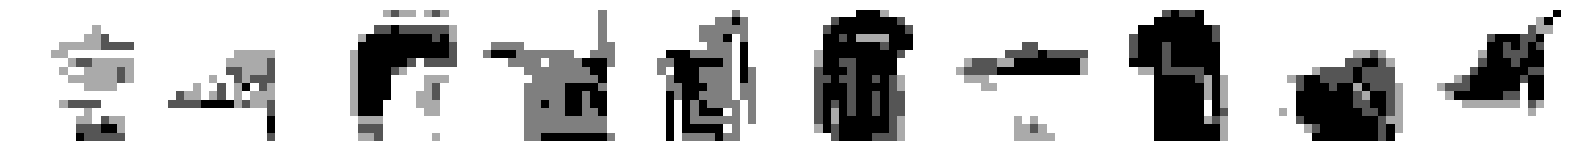

469/469 [==============================] - 29s 60ms/step - loss: 0.3478
Epoch 21/150
468/469 [============================>.] - ETA: 0s - loss: 0.3469  
Saved to ./output/generated_img_020.png


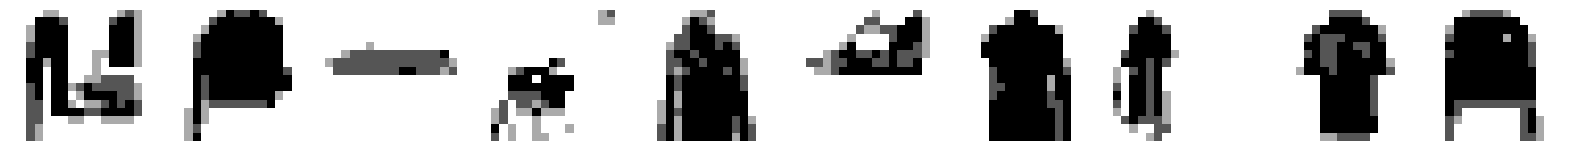

469/469 [==============================] - 31s 66ms/step - loss: 0.3469
Epoch 22/150
469/469 [==============================] - ETA: 0s - loss: 0.3462  
Saved to ./output/generated_img_021.png


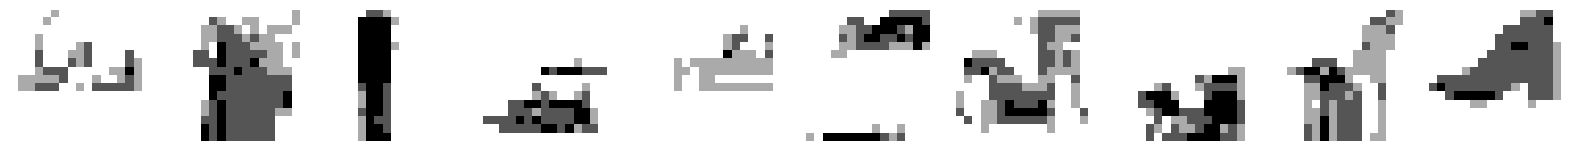

469/469 [==============================] - 31s 65ms/step - loss: 0.3462
Epoch 23/150
467/469 [============================>.] - ETA: 0s - loss: 0.3453  
Saved to ./output/generated_img_022.png


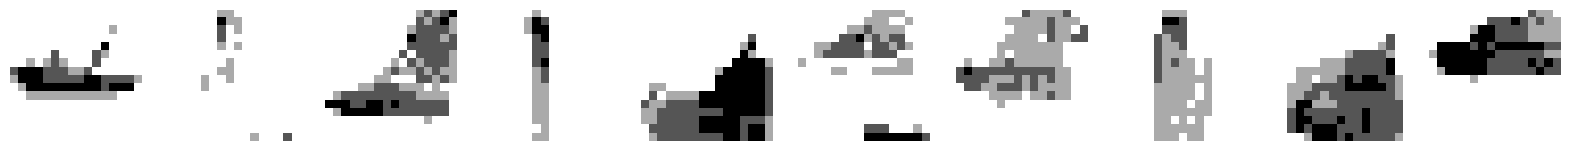

469/469 [==============================] - 31s 66ms/step - loss: 0.3453
Epoch 24/150
468/469 [============================>.] - ETA: 0s - loss: 0.3449  
Saved to ./output/generated_img_023.png


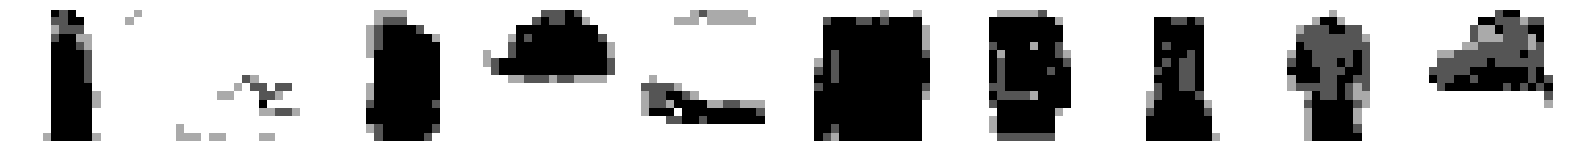

469/469 [==============================] - 30s 65ms/step - loss: 0.3449
Epoch 25/150
468/469 [============================>.] - ETA: 0s - loss: 0.3441  
Saved to ./output/generated_img_024.png


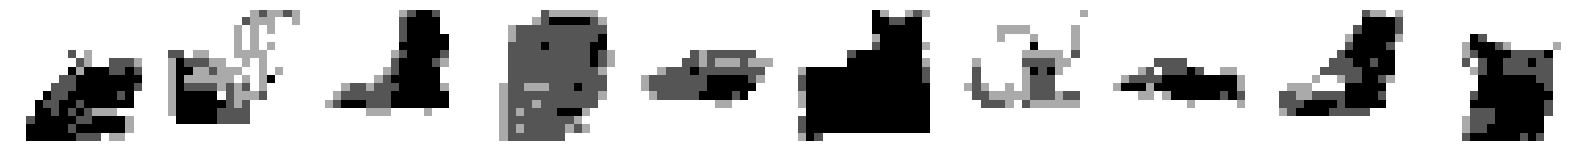

469/469 [==============================] - 31s 65ms/step - loss: 0.3441
Epoch 26/150
469/469 [==============================] - ETA: 0s - loss: 0.3438  
Saved to ./output/generated_img_025.png


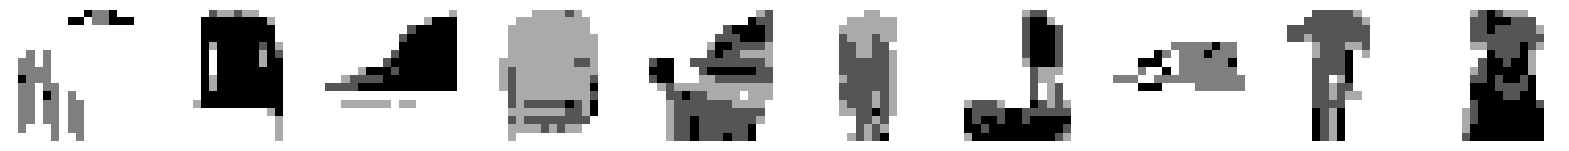

469/469 [==============================] - 31s 66ms/step - loss: 0.3438
Epoch 27/150
469/469 [==============================] - ETA: 0s - loss: 0.3431  
Saved to ./output/generated_img_026.png


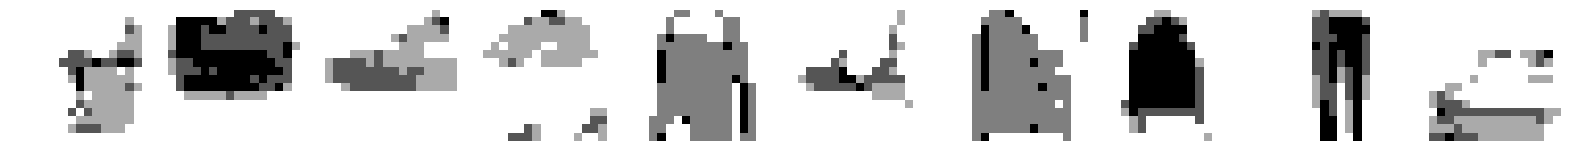

469/469 [==============================] - 31s 65ms/step - loss: 0.3431
Epoch 28/150
469/469 [==============================] - ETA: 0s - loss: 0.3426  
Saved to ./output/generated_img_027.png


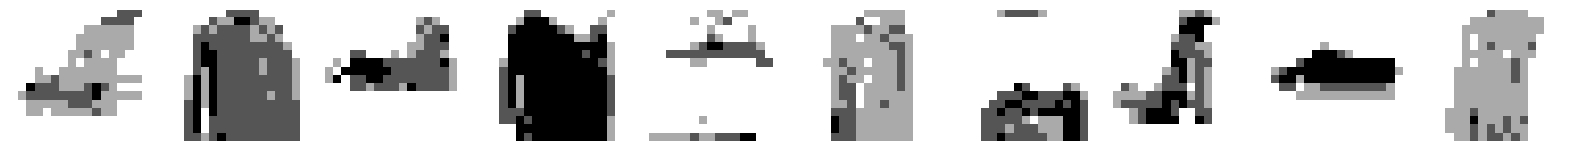

469/469 [==============================] - 31s 66ms/step - loss: 0.3426
Epoch 29/150
468/469 [============================>.] - ETA: 0s - loss: 0.3423  
Saved to ./output/generated_img_028.png


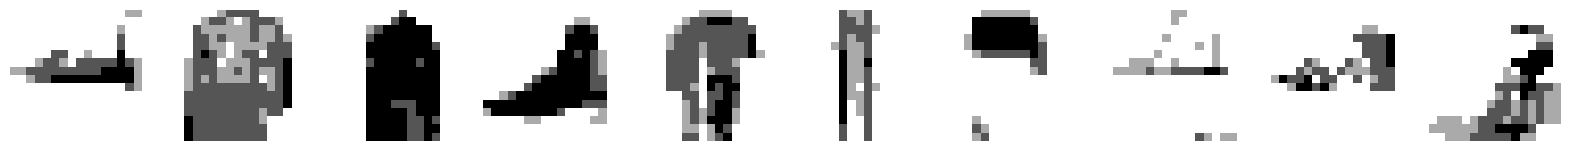

469/469 [==============================] - 28s 59ms/step - loss: 0.3423
Epoch 30/150
468/469 [============================>.] - ETA: 0s - loss: 0.3416  
Saved to ./output/generated_img_029.png


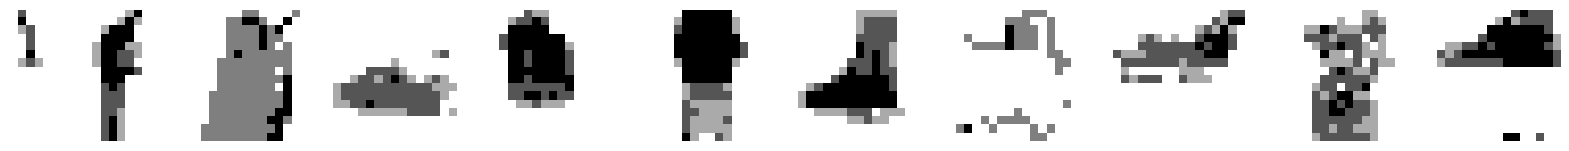

469/469 [==============================] - 28s 60ms/step - loss: 0.3415
Epoch 31/150
468/469 [============================>.] - ETA: 0s - loss: 0.3412  
Saved to ./output/generated_img_030.png


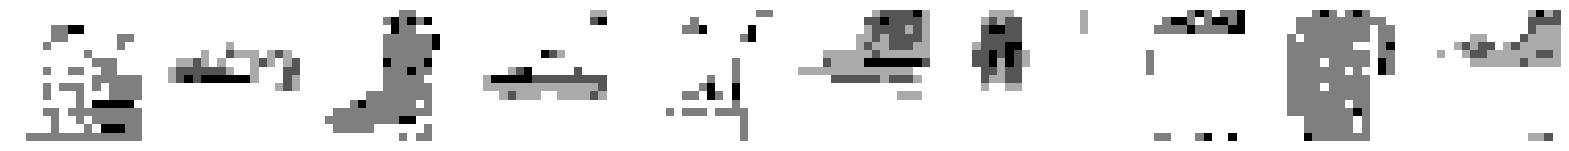

469/469 [==============================] - 29s 61ms/step - loss: 0.3412
Epoch 32/150
468/469 [============================>.] - ETA: 0s - loss: 0.3409  
Saved to ./output/generated_img_031.png


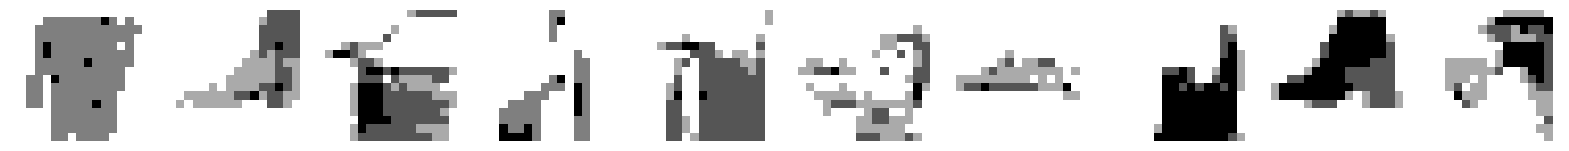

469/469 [==============================] - 28s 59ms/step - loss: 0.3408
Epoch 33/150
468/469 [============================>.] - ETA: 0s - loss: 0.3403  
Saved to ./output/generated_img_032.png


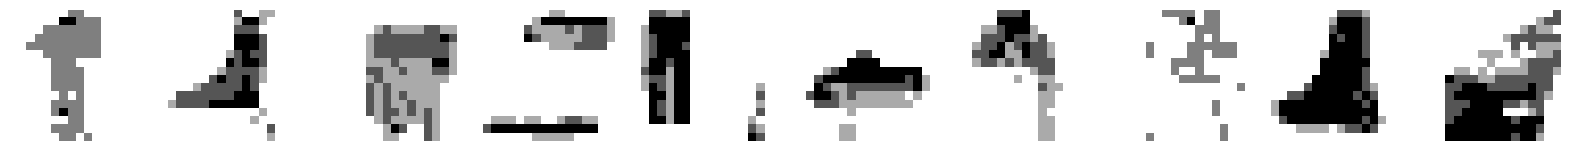

469/469 [==============================] - 30s 64ms/step - loss: 0.3403
Epoch 34/150
467/469 [============================>.] - ETA: 0s - loss: 0.3401  
Saved to ./output/generated_img_033.png


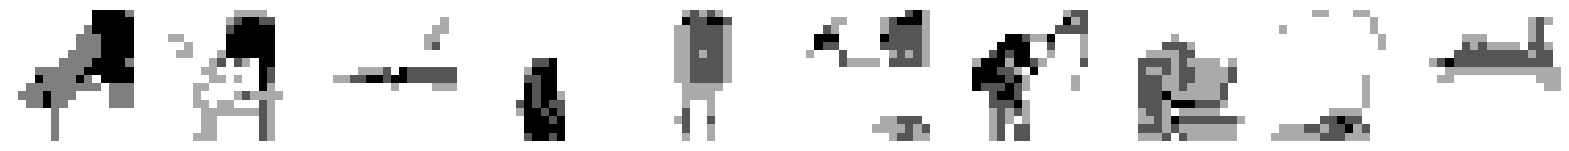

469/469 [==============================] - 28s 60ms/step - loss: 0.3401
Epoch 35/150
468/469 [============================>.] - ETA: 0s - loss: 0.3396  
Saved to ./output/generated_img_034.png


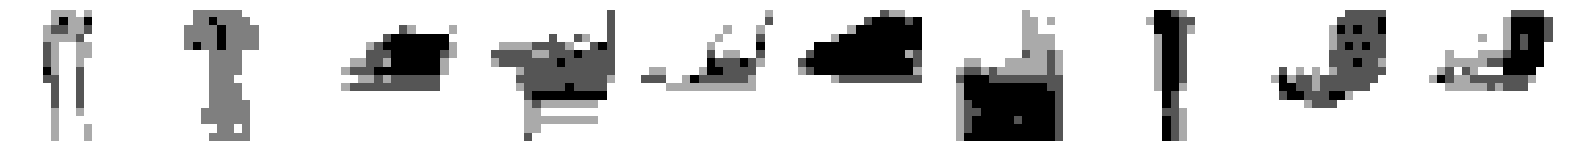

469/469 [==============================] - 30s 63ms/step - loss: 0.3396
Epoch 36/150
469/469 [==============================] - ETA: 0s - loss: 0.3391  
Saved to ./output/generated_img_035.png


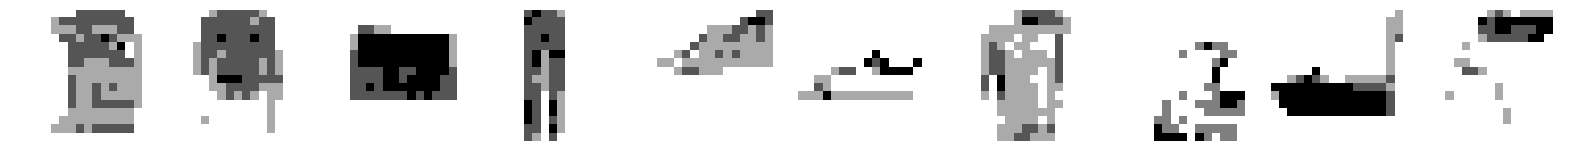

469/469 [==============================] - 31s 65ms/step - loss: 0.3391
Epoch 37/150
468/469 [============================>.] - ETA: 0s - loss: 0.3390  
Saved to ./output/generated_img_036.png


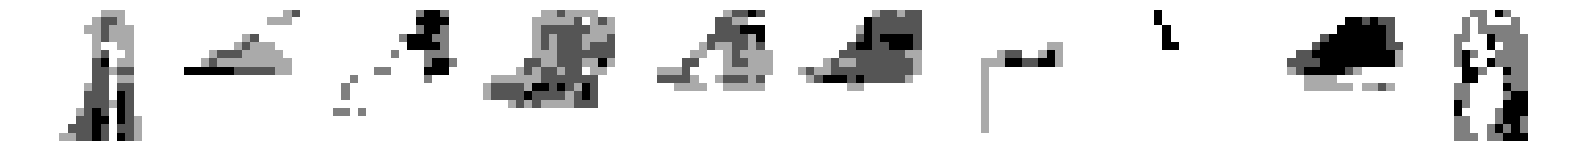

469/469 [==============================] - 30s 64ms/step - loss: 0.3390
Epoch 38/150
468/469 [============================>.] - ETA: 0s - loss: 0.3384  
Saved to ./output/generated_img_037.png


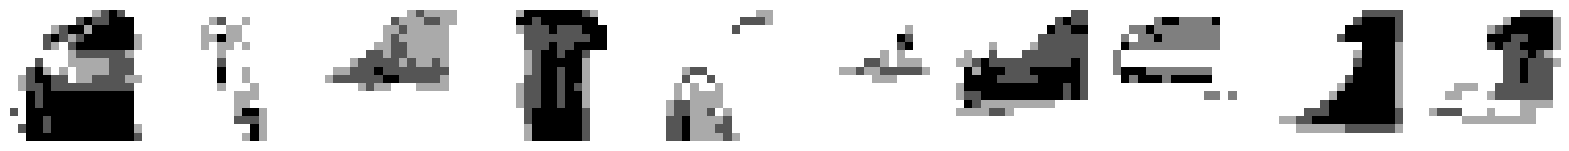

469/469 [==============================] - 30s 64ms/step - loss: 0.3384
Epoch 39/150
468/469 [============================>.] - ETA: 0s - loss: 0.3382  
Saved to ./output/generated_img_038.png


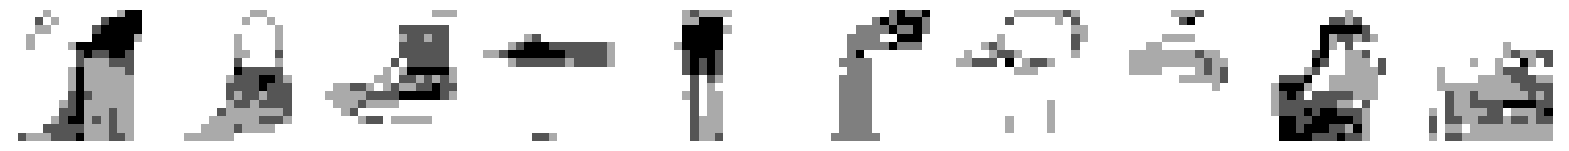

469/469 [==============================] - 30s 64ms/step - loss: 0.3382
Epoch 40/150
468/469 [============================>.] - ETA: 0s - loss: 0.3379  
Saved to ./output/generated_img_039.png


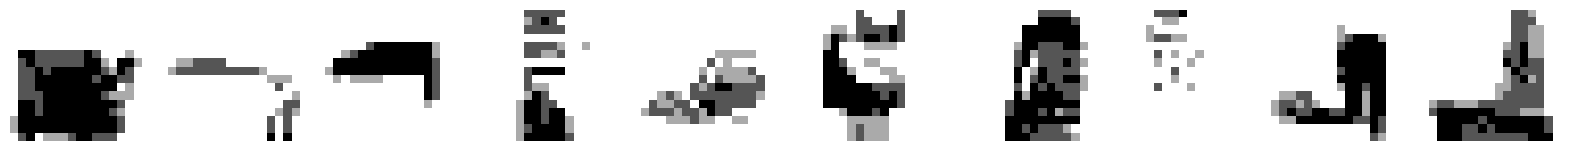

469/469 [==============================] - 30s 64ms/step - loss: 0.3379
Epoch 41/150
469/469 [==============================] - ETA: 0s - loss: 0.3374  
Saved to ./output/generated_img_040.png


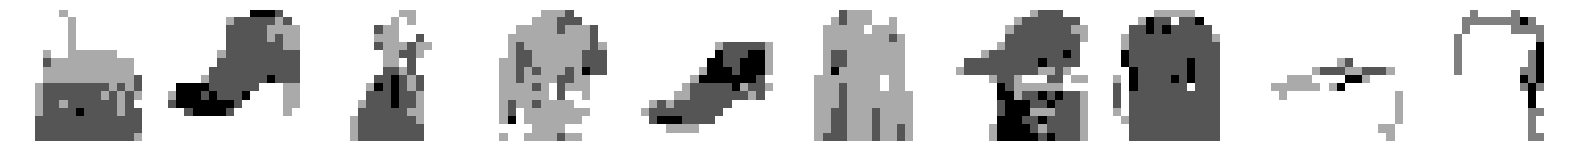

469/469 [==============================] - 30s 64ms/step - loss: 0.3374
Epoch 42/150
468/469 [============================>.] - ETA: 0s - loss: 0.3372  
Saved to ./output/generated_img_041.png


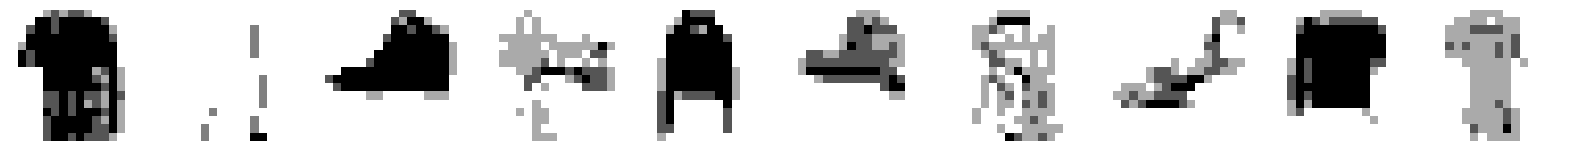

469/469 [==============================] - 30s 64ms/step - loss: 0.3372
Epoch 43/150
468/469 [============================>.] - ETA: 0s - loss: 0.3368  
Saved to ./output/generated_img_042.png


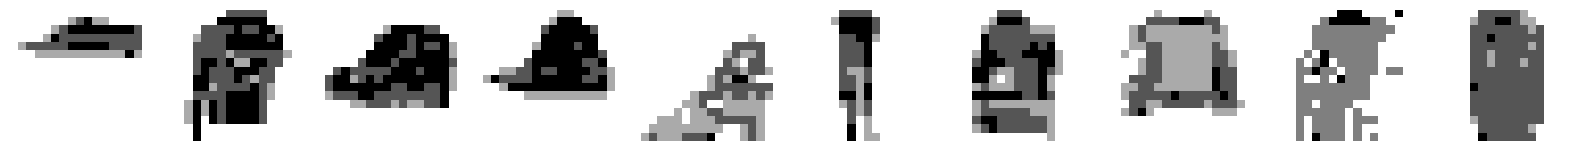

469/469 [==============================] - 31s 66ms/step - loss: 0.3369
Epoch 44/150
468/469 [============================>.] - ETA: 0s - loss: 0.3367  
Saved to ./output/generated_img_043.png


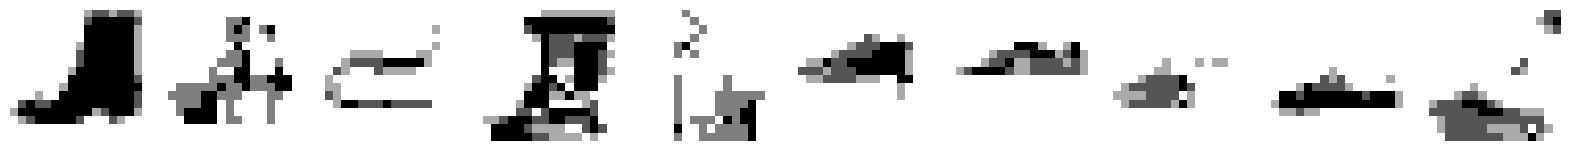

469/469 [==============================] - 30s 64ms/step - loss: 0.3367
Epoch 45/150
468/469 [============================>.] - ETA: 0s - loss: 0.3362  
Saved to ./output/generated_img_044.png


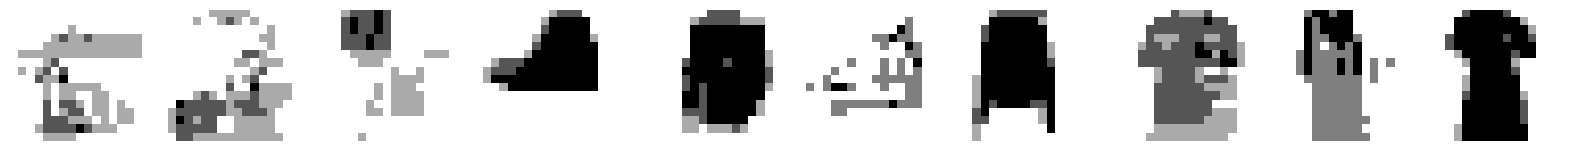

469/469 [==============================] - 30s 64ms/step - loss: 0.3362
Epoch 46/150
468/469 [============================>.] - ETA: 0s - loss: 0.3361  
Saved to ./output/generated_img_045.png


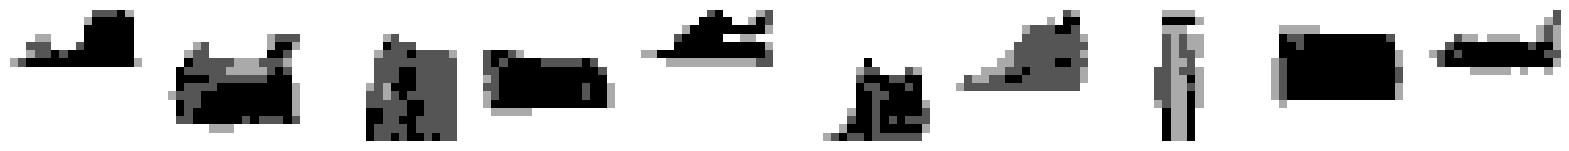

469/469 [==============================] - 31s 65ms/step - loss: 0.3360
Epoch 47/150
467/469 [============================>.] - ETA: 0s - loss: 0.3358  
Saved to ./output/generated_img_046.png


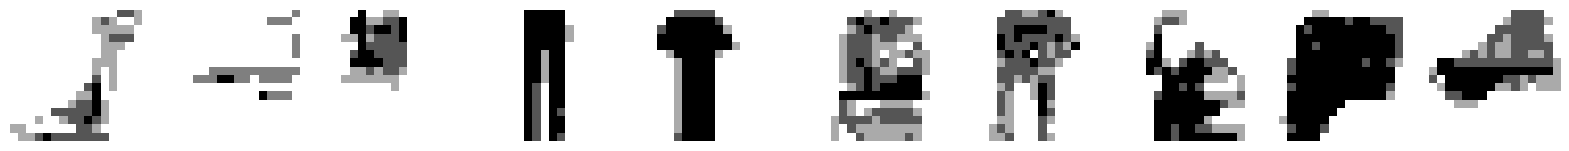

469/469 [==============================] - 32s 69ms/step - loss: 0.3358
Epoch 48/150
468/469 [============================>.] - ETA: 0s - loss: 0.3356  
Saved to ./output/generated_img_047.png


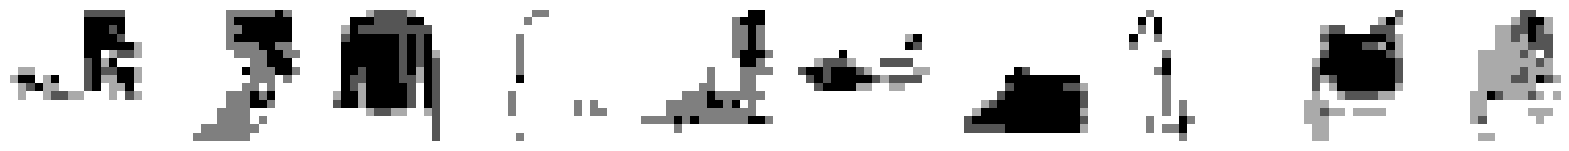

469/469 [==============================] - 33s 69ms/step - loss: 0.3356
Epoch 49/150
469/469 [==============================] - ETA: 0s - loss: 0.3353  
Saved to ./output/generated_img_048.png


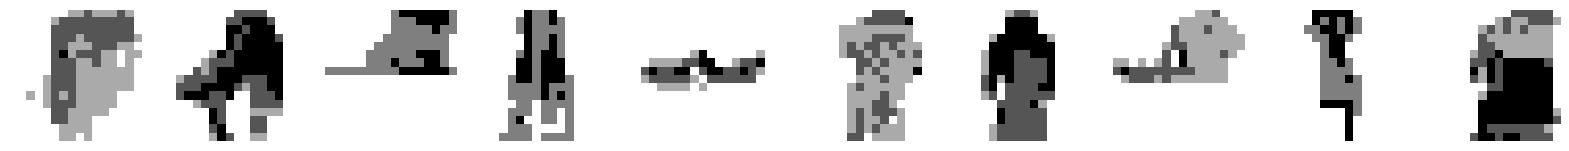

469/469 [==============================] - 33s 69ms/step - loss: 0.3353
Epoch 50/150
469/469 [==============================] - ETA: 0s - loss: 0.3350  
Saved to ./output/generated_img_049.png


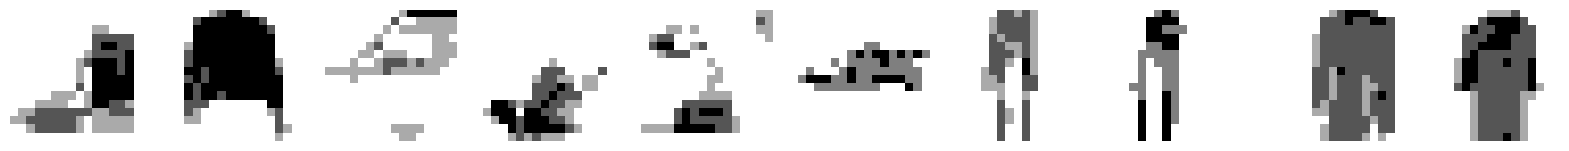

469/469 [==============================] - 31s 65ms/step - loss: 0.3350
Epoch 51/150
468/469 [============================>.] - ETA: 0s - loss: 0.3351  
Saved to ./output/generated_img_050.png


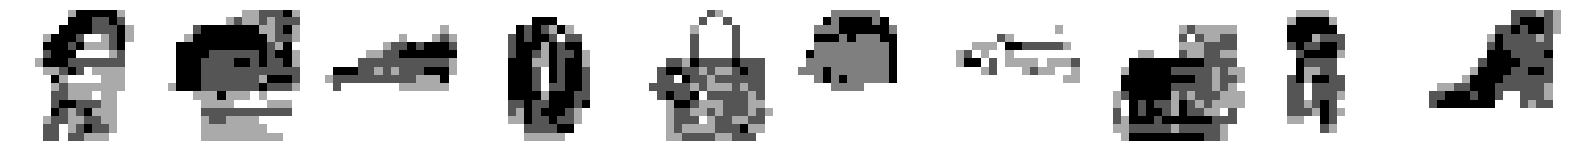

469/469 [==============================] - 29s 61ms/step - loss: 0.3351
Epoch 52/150
468/469 [============================>.] - ETA: 0s - loss: 0.3345  
Saved to ./output/generated_img_051.png


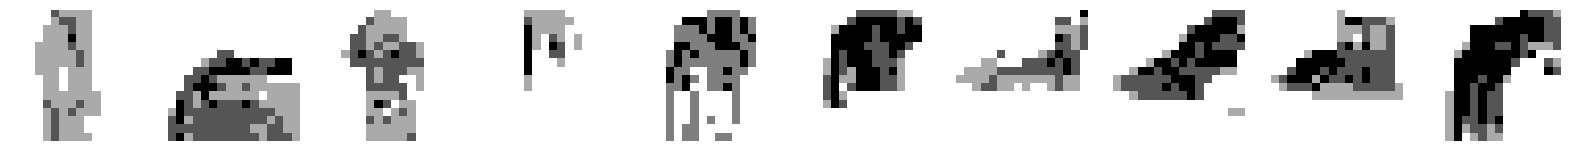

469/469 [==============================] - 30s 64ms/step - loss: 0.3345
Epoch 53/150
469/469 [==============================] - ETA: 0s - loss: 0.3344  
Saved to ./output/generated_img_052.png


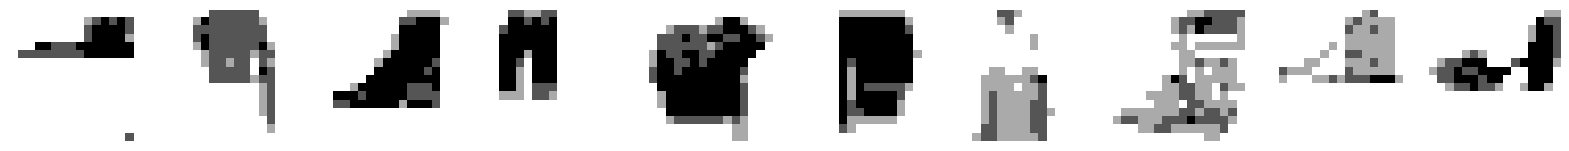

469/469 [==============================] - 28s 59ms/step - loss: 0.3344
Epoch 54/150
468/469 [============================>.] - ETA: 0s - loss: 0.3340  
Saved to ./output/generated_img_053.png


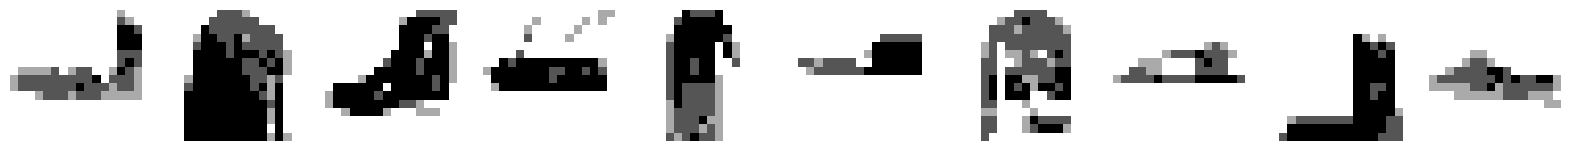

469/469 [==============================] - 28s 59ms/step - loss: 0.3340
Epoch 55/150
468/469 [============================>.] - ETA: 0s - loss: 0.3338  
Saved to ./output/generated_img_054.png


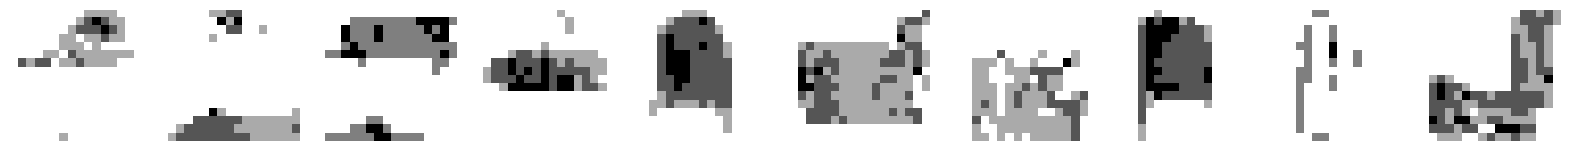

469/469 [==============================] - 28s 60ms/step - loss: 0.3338
Epoch 56/150
469/469 [==============================] - ETA: 0s - loss: 0.3339  
Saved to ./output/generated_img_055.png


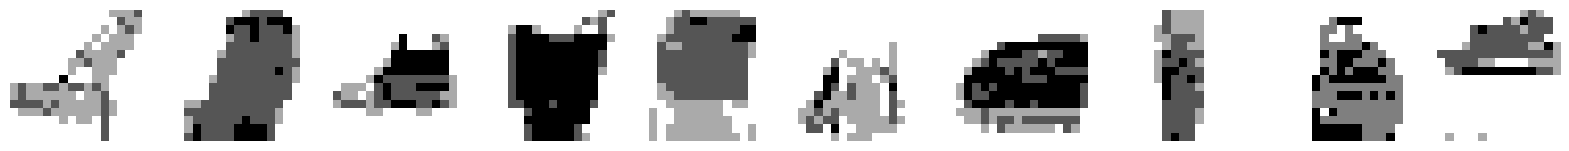

469/469 [==============================] - 28s 60ms/step - loss: 0.3339
Epoch 57/150
468/469 [============================>.] - ETA: 0s - loss: 0.3334  
Saved to ./output/generated_img_056.png


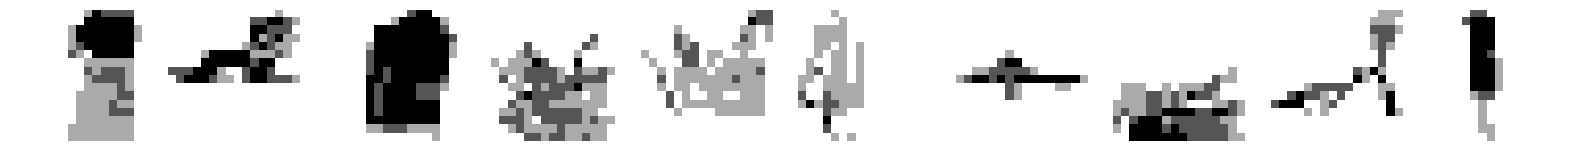

469/469 [==============================] - 28s 59ms/step - loss: 0.3334
Epoch 58/150
468/469 [============================>.] - ETA: 0s - loss: 0.3333  
Saved to ./output/generated_img_057.png


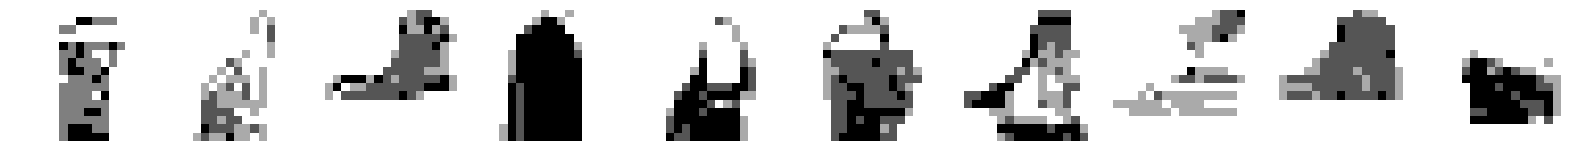

469/469 [==============================] - 28s 59ms/step - loss: 0.3333
Epoch 59/150
467/469 [============================>.] - ETA: 0s - loss: 0.3332  
Saved to ./output/generated_img_058.png


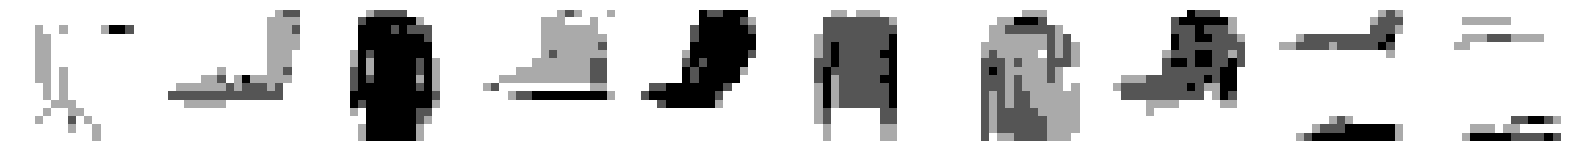

469/469 [==============================] - 28s 59ms/step - loss: 0.3331
Epoch 60/150
469/469 [==============================] - ETA: 0s - loss: 0.3329  
Saved to ./output/generated_img_059.png


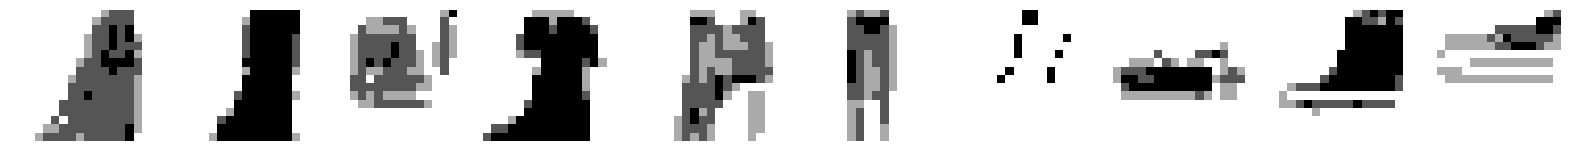

469/469 [==============================] - 28s 59ms/step - loss: 0.3329
Epoch 61/150
469/469 [==============================] - ETA: 0s - loss: 0.3326  
Saved to ./output/generated_img_060.png


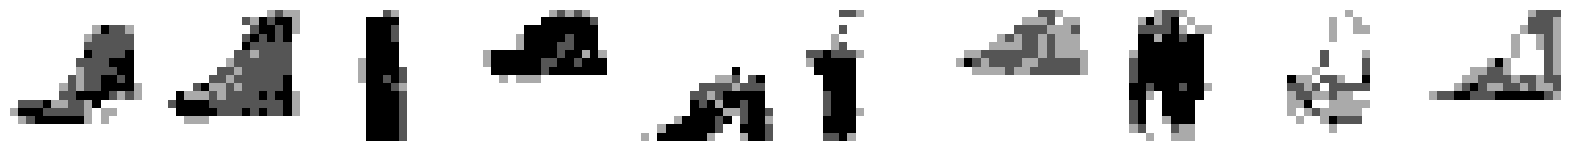

469/469 [==============================] - 28s 59ms/step - loss: 0.3326
Epoch 62/150
468/469 [============================>.] - ETA: 0s - loss: 0.3327  
Saved to ./output/generated_img_061.png


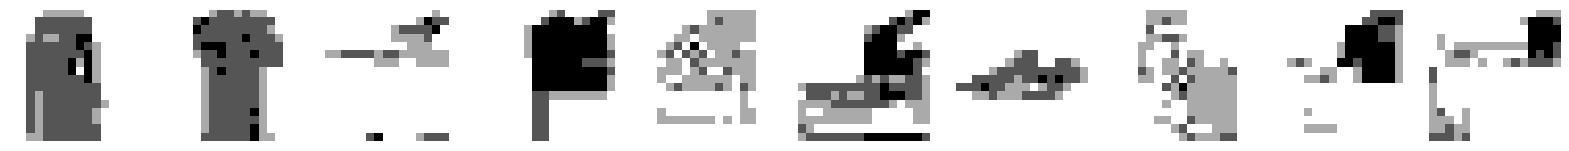

469/469 [==============================] - 28s 59ms/step - loss: 0.3327
Epoch 63/150
468/469 [============================>.] - ETA: 0s - loss: 0.3324  
Saved to ./output/generated_img_062.png


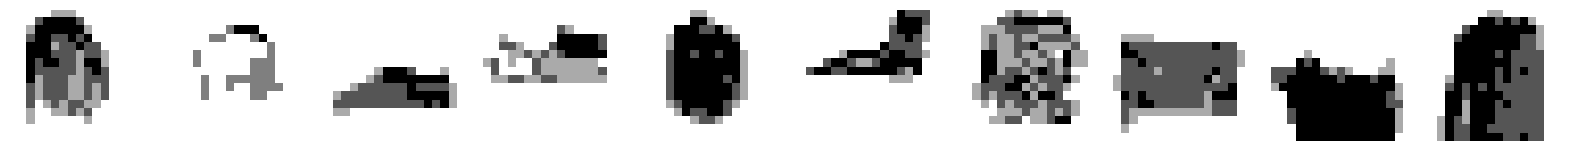

469/469 [==============================] - 29s 60ms/step - loss: 0.3324
Epoch 64/150
468/469 [============================>.] - ETA: 0s - loss: 0.3321  
Saved to ./output/generated_img_063.png


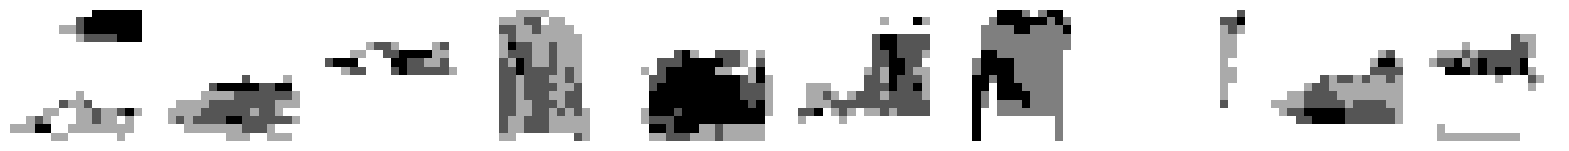

469/469 [==============================] - 28s 60ms/step - loss: 0.3321
Epoch 65/150
468/469 [============================>.] - ETA: 0s - loss: 0.3319  
Saved to ./output/generated_img_064.png


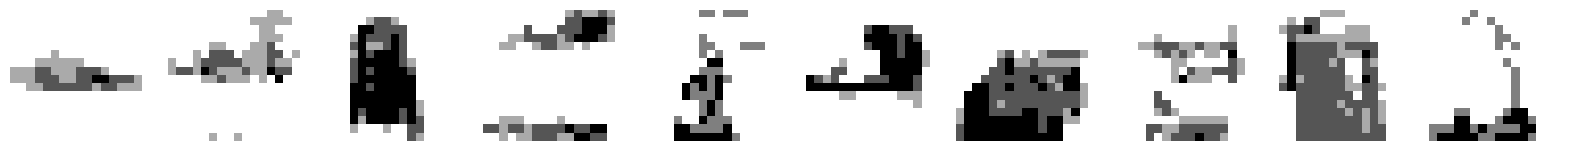

469/469 [==============================] - 28s 59ms/step - loss: 0.3320
Epoch 66/150
469/469 [==============================] - ETA: 0s - loss: 0.3318  
Saved to ./output/generated_img_065.png


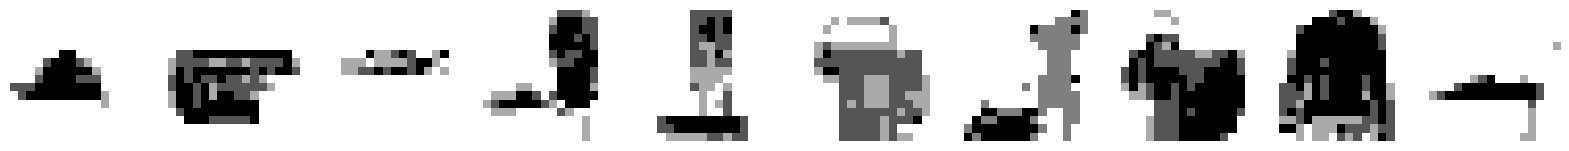

469/469 [==============================] - 28s 59ms/step - loss: 0.3318
Epoch 67/150
469/469 [==============================] - ETA: 0s - loss: 0.3316  
Saved to ./output/generated_img_066.png


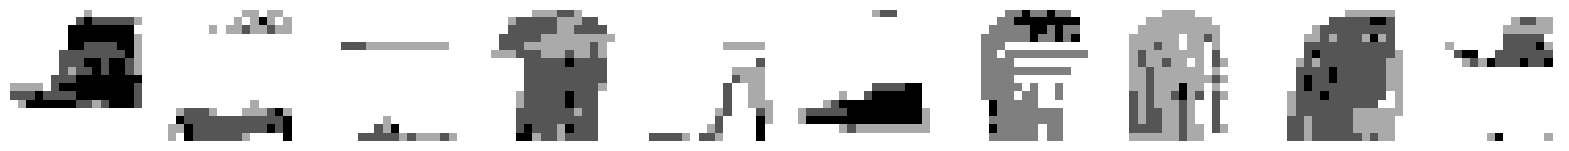

469/469 [==============================] - 28s 59ms/step - loss: 0.3316
Epoch 68/150
469/469 [==============================] - ETA: 0s - loss: 0.3315  
Saved to ./output/generated_img_067.png


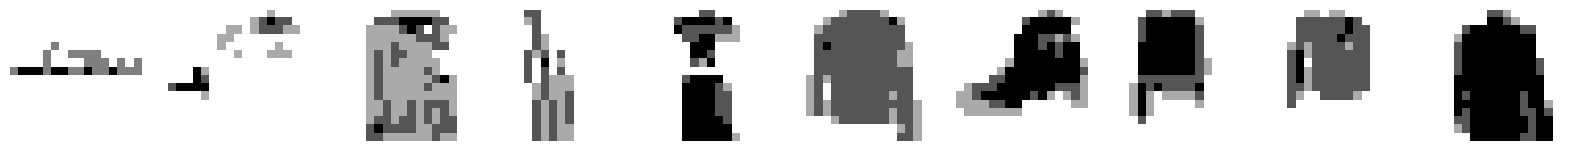

469/469 [==============================] - 28s 59ms/step - loss: 0.3315
Epoch 69/150
469/469 [==============================] - ETA: 0s - loss: 0.3314  
Saved to ./output/generated_img_068.png


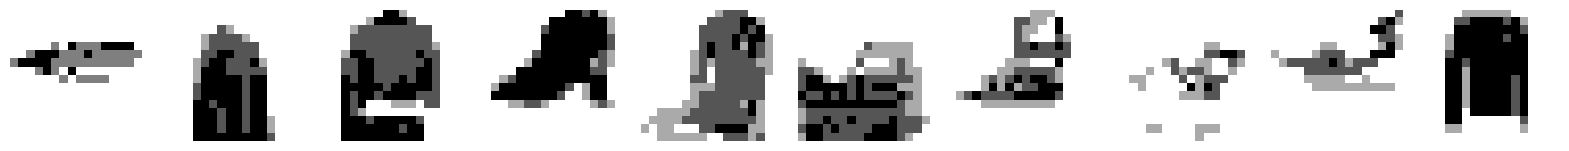

469/469 [==============================] - 28s 60ms/step - loss: 0.3314
Epoch 70/150
467/469 [============================>.] - ETA: 0s - loss: 0.3312  
Saved to ./output/generated_img_069.png


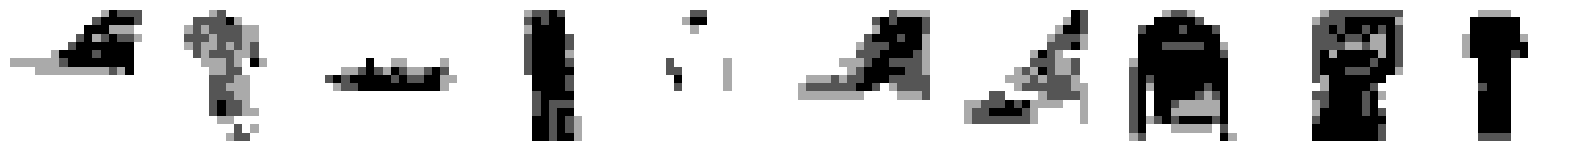

469/469 [==============================] - 28s 59ms/step - loss: 0.3312
Epoch 71/150
467/469 [============================>.] - ETA: 0s - loss: 0.3311  
Saved to ./output/generated_img_070.png


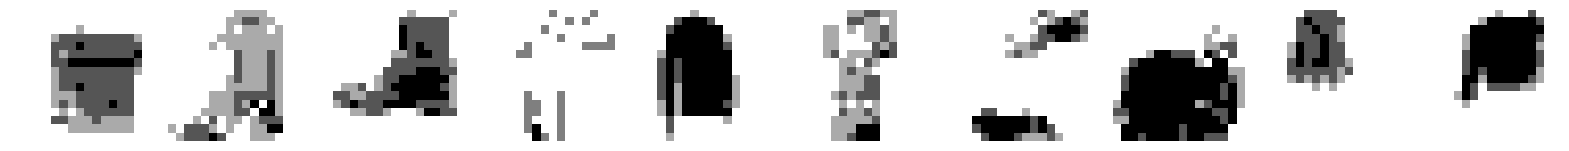

469/469 [==============================] - 28s 60ms/step - loss: 0.3311
Epoch 72/150
468/469 [============================>.] - ETA: 0s - loss: 0.3309  
Saved to ./output/generated_img_071.png


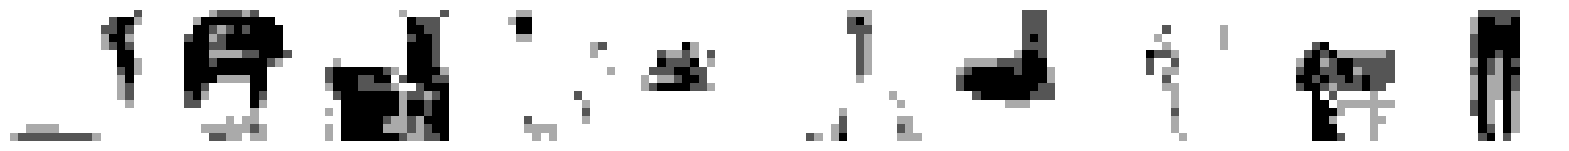

469/469 [==============================] - 28s 60ms/step - loss: 0.3310
Epoch 73/150
468/469 [============================>.] - ETA: 0s - loss: 0.3307  
Saved to ./output/generated_img_072.png


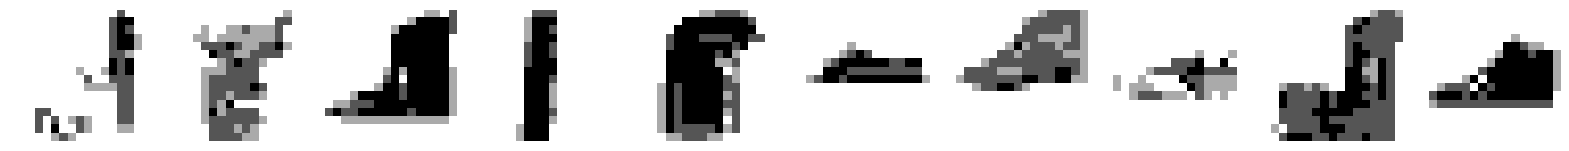

469/469 [==============================] - 32s 67ms/step - loss: 0.3307
Epoch 74/150
468/469 [============================>.] - ETA: 0s - loss: 0.3304  
Saved to ./output/generated_img_073.png


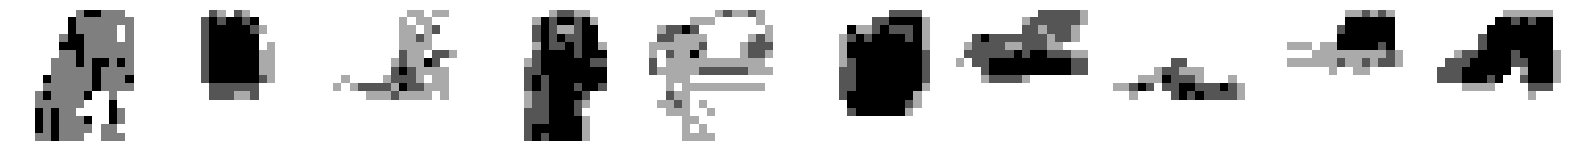

469/469 [==============================] - 31s 65ms/step - loss: 0.3304
Epoch 75/150
468/469 [============================>.] - ETA: 0s - loss: 0.3305  
Saved to ./output/generated_img_074.png


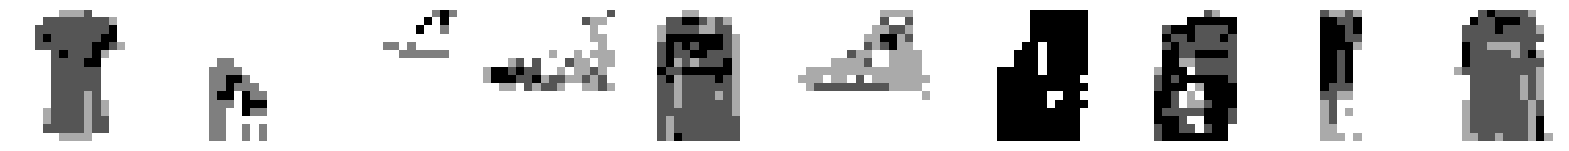

469/469 [==============================] - 31s 65ms/step - loss: 0.3305
Epoch 76/150
469/469 [==============================] - ETA: 0s - loss: 0.3302  
Saved to ./output/generated_img_075.png


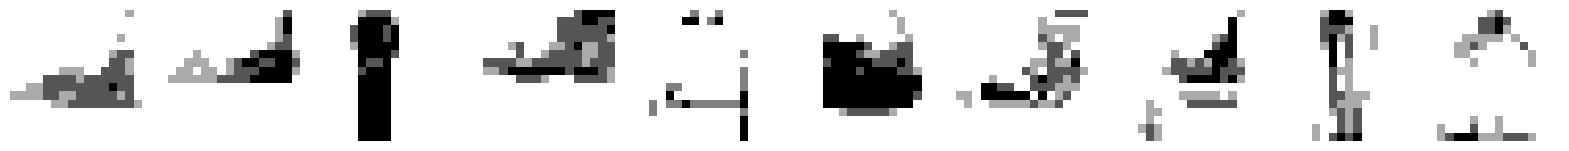

469/469 [==============================] - 30s 64ms/step - loss: 0.3302
Epoch 77/150
469/469 [==============================] - ETA: 0s - loss: 0.3302  
Saved to ./output/generated_img_076.png


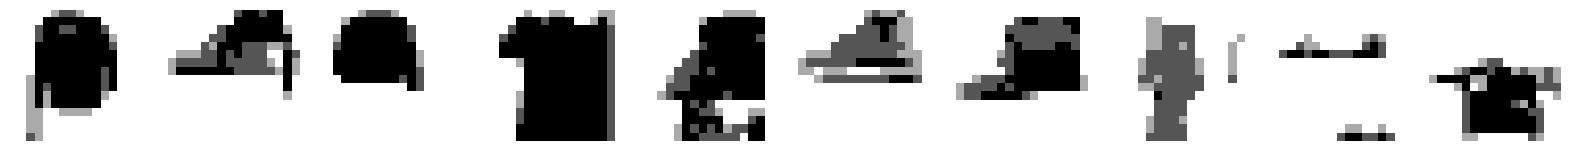

469/469 [==============================] - 30s 65ms/step - loss: 0.3302
Epoch 78/150
468/469 [============================>.] - ETA: 0s - loss: 0.3300  
Saved to ./output/generated_img_077.png


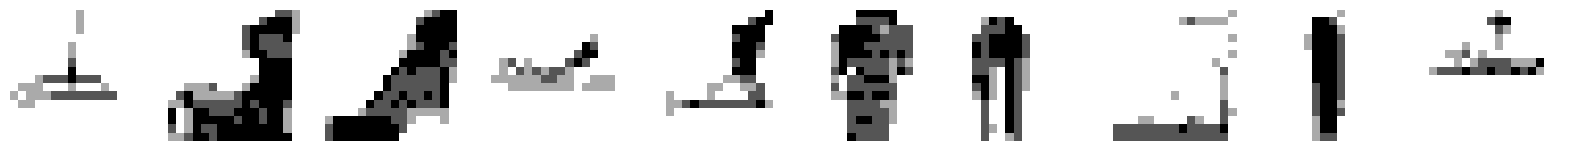

469/469 [==============================] - 30s 64ms/step - loss: 0.3300
Epoch 79/150
468/469 [============================>.] - ETA: 0s - loss: 0.3298  
Saved to ./output/generated_img_078.png


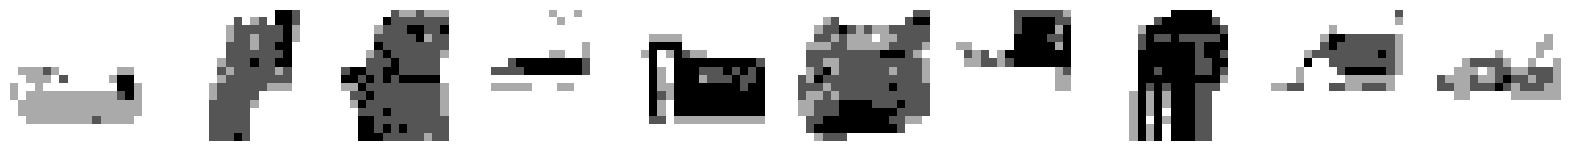

469/469 [==============================] - 31s 65ms/step - loss: 0.3298
Epoch 80/150
468/469 [============================>.] - ETA: 0s - loss: 0.3299  
Saved to ./output/generated_img_079.png


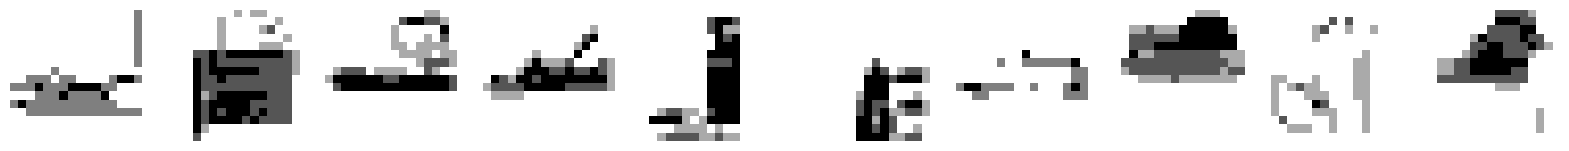

469/469 [==============================] - 31s 65ms/step - loss: 0.3298
Epoch 81/150
468/469 [============================>.] - ETA: 0s - loss: 0.3296  
Saved to ./output/generated_img_080.png


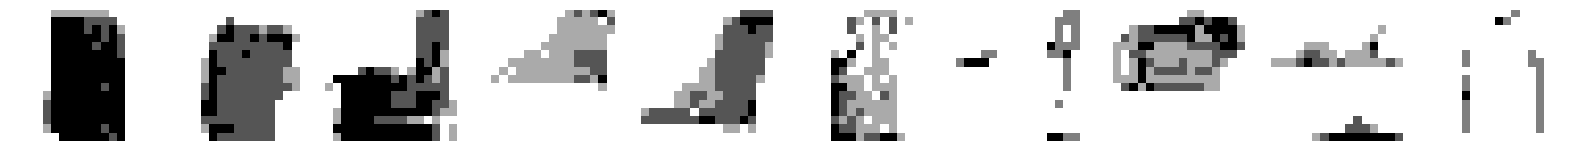

469/469 [==============================] - 31s 65ms/step - loss: 0.3296
Epoch 82/150
468/469 [============================>.] - ETA: 0s - loss: 0.3294  
Saved to ./output/generated_img_081.png


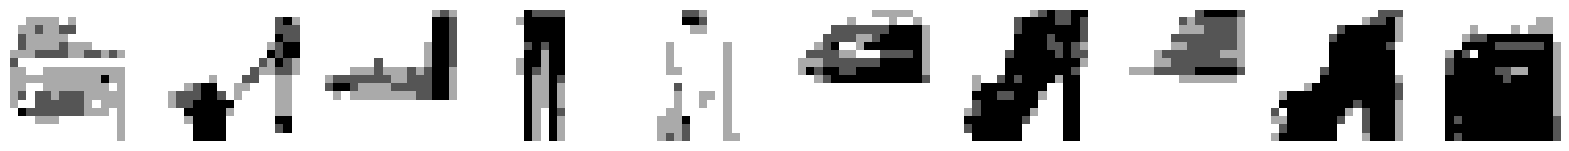

469/469 [==============================] - 31s 64ms/step - loss: 0.3294
Epoch 83/150
468/469 [============================>.] - ETA: 0s - loss: 0.3293  
Saved to ./output/generated_img_082.png


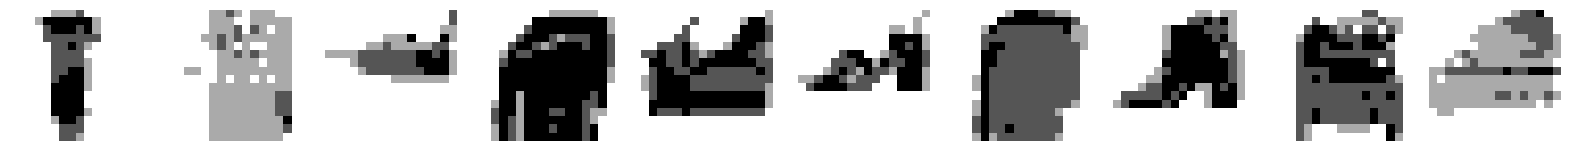

469/469 [==============================] - 31s 66ms/step - loss: 0.3293
Epoch 84/150
469/469 [==============================] - ETA: 0s - loss: 0.3291  
Saved to ./output/generated_img_083.png


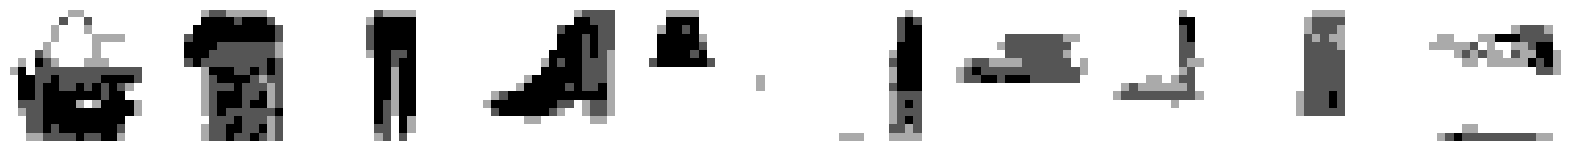

469/469 [==============================] - 30s 64ms/step - loss: 0.3291
Epoch 85/150
469/469 [==============================] - ETA: 0s - loss: 0.3291  
Saved to ./output/generated_img_084.png


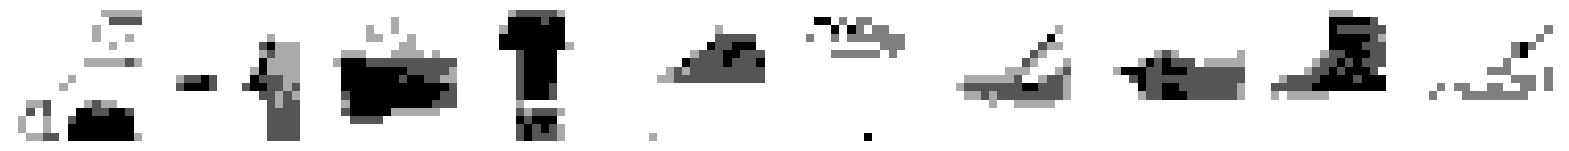

469/469 [==============================] - 31s 65ms/step - loss: 0.3291
Epoch 86/150
469/469 [==============================] - ETA: 0s - loss: 0.3291  
Saved to ./output/generated_img_085.png


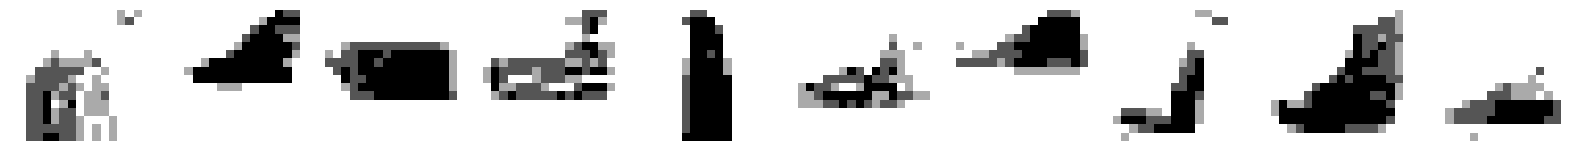

469/469 [==============================] - 28s 60ms/step - loss: 0.3291
Epoch 87/150
468/469 [============================>.] - ETA: 0s - loss: 0.3287  
Saved to ./output/generated_img_086.png


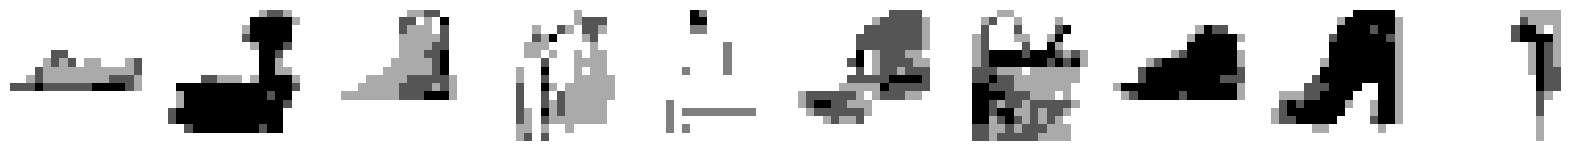

469/469 [==============================] - 31s 66ms/step - loss: 0.3287
Epoch 88/150
469/469 [==============================] - ETA: 0s - loss: 0.3287  
Saved to ./output/generated_img_087.png


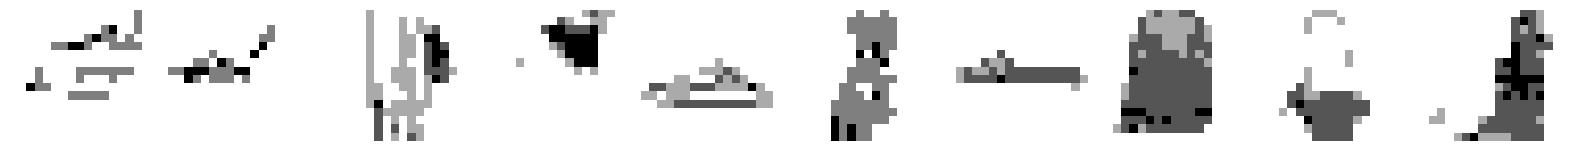

469/469 [==============================] - 32s 68ms/step - loss: 0.3287
Epoch 89/150
468/469 [============================>.] - ETA: 0s - loss: 0.3285  
Saved to ./output/generated_img_088.png


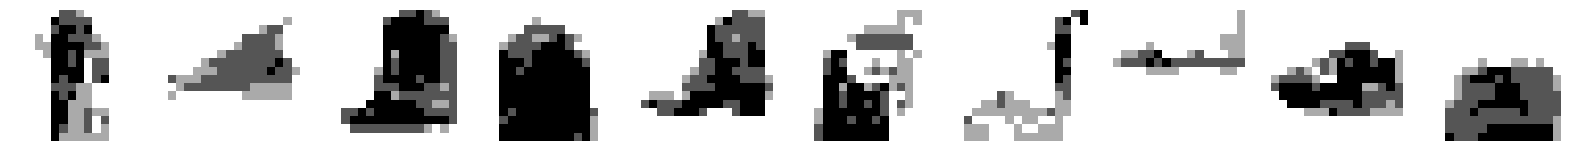

469/469 [==============================] - 31s 66ms/step - loss: 0.3286
Epoch 90/150
468/469 [============================>.] - ETA: 0s - loss: 0.3285  
Saved to ./output/generated_img_089.png


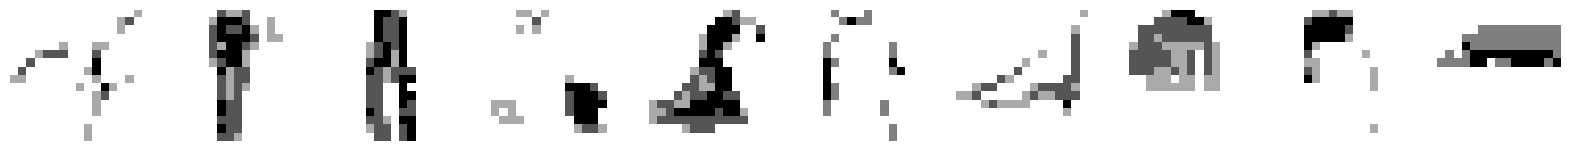

469/469 [==============================] - 32s 67ms/step - loss: 0.3285
Epoch 91/150
469/469 [==============================] - ETA: 0s - loss: 0.3284  
Saved to ./output/generated_img_090.png


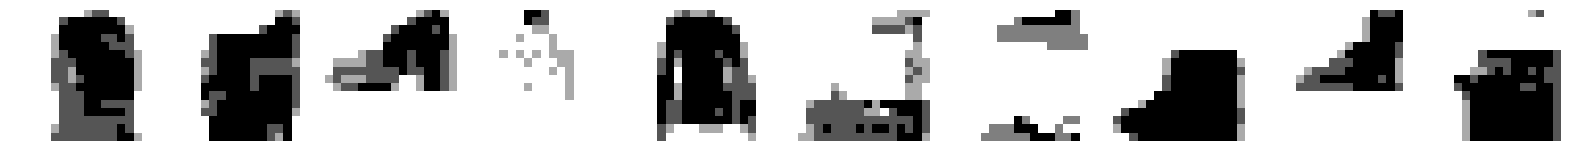

469/469 [==============================] - 31s 65ms/step - loss: 0.3284
Epoch 92/150
467/469 [============================>.] - ETA: 0s - loss: 0.3282  
Saved to ./output/generated_img_091.png


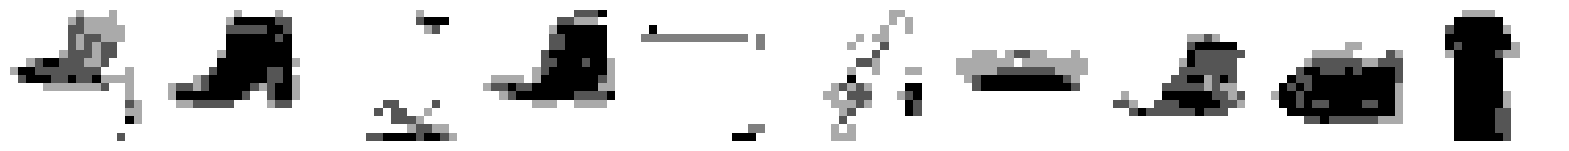

469/469 [==============================] - 30s 63ms/step - loss: 0.3282
Epoch 93/150
468/469 [============================>.] - ETA: 0s - loss: 0.3283  
Saved to ./output/generated_img_092.png


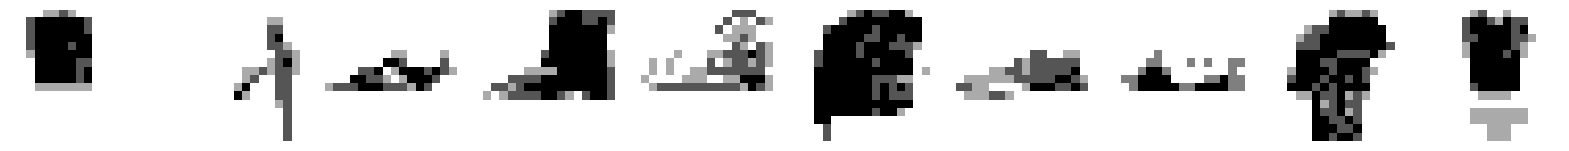

469/469 [==============================] - 28s 60ms/step - loss: 0.3283
Epoch 94/150
468/469 [============================>.] - ETA: 0s - loss: 0.3280  
Saved to ./output/generated_img_093.png


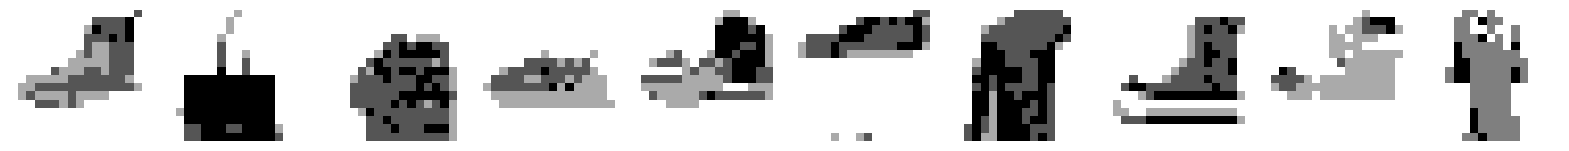

469/469 [==============================] - 28s 60ms/step - loss: 0.3280
Epoch 95/150
469/469 [==============================] - ETA: 0s - loss: 0.3279  
Saved to ./output/generated_img_094.png


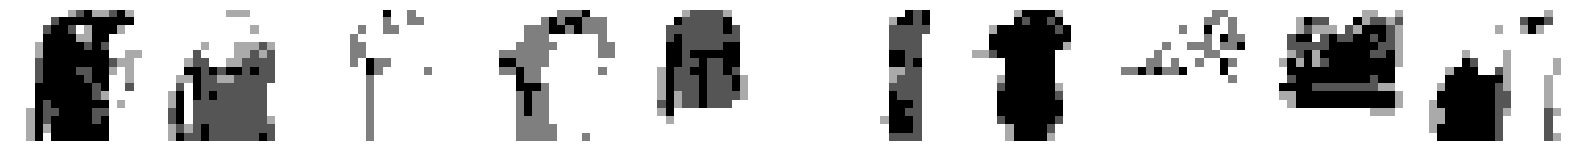

469/469 [==============================] - 29s 61ms/step - loss: 0.3279
Epoch 96/150
468/469 [============================>.] - ETA: 0s - loss: 0.3278  
Saved to ./output/generated_img_095.png


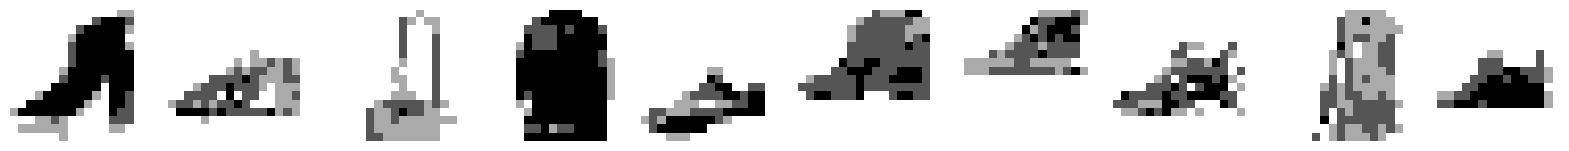

469/469 [==============================] - 28s 60ms/step - loss: 0.3278
Epoch 97/150
468/469 [============================>.] - ETA: 0s - loss: 0.3276  
Saved to ./output/generated_img_096.png


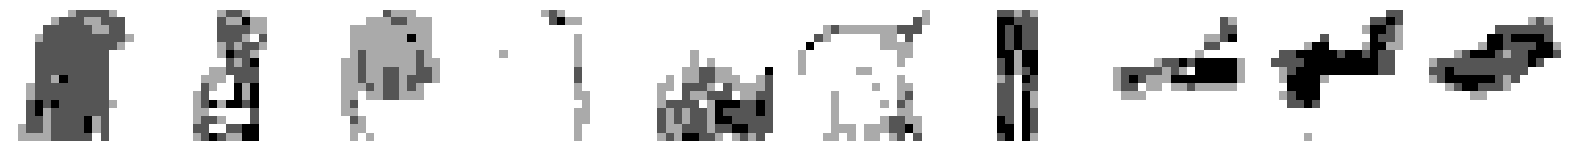

469/469 [==============================] - 28s 60ms/step - loss: 0.3276
Epoch 98/150
469/469 [==============================] - ETA: 0s - loss: 0.3277  
Saved to ./output/generated_img_097.png


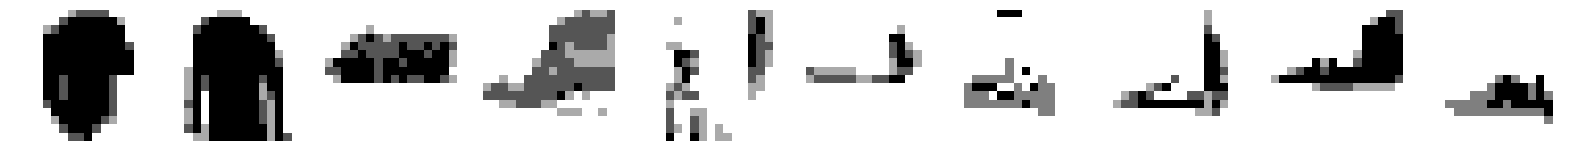

469/469 [==============================] - 29s 61ms/step - loss: 0.3277
Epoch 99/150
468/469 [============================>.] - ETA: 0s - loss: 0.3273  
Saved to ./output/generated_img_098.png


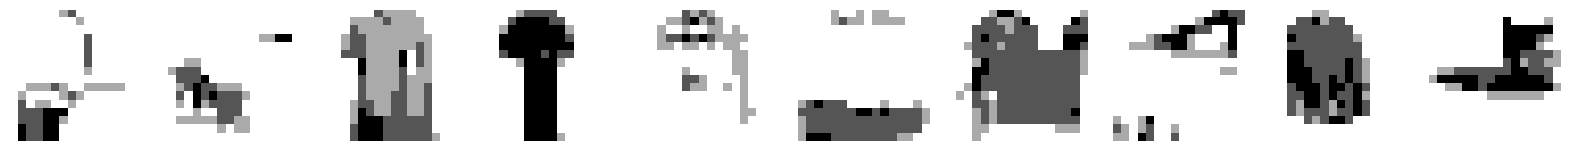

469/469 [==============================] - 29s 61ms/step - loss: 0.3273
Epoch 100/150
467/469 [============================>.] - ETA: 0s - loss: 0.3274  
Saved to ./output/generated_img_099.png


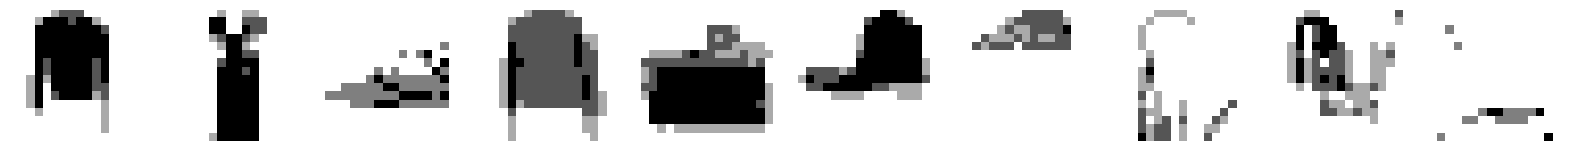

469/469 [==============================] - 29s 61ms/step - loss: 0.3274
Epoch 101/150
469/469 [==============================] - ETA: 0s - loss: 0.3273  
Saved to ./output/generated_img_100.png


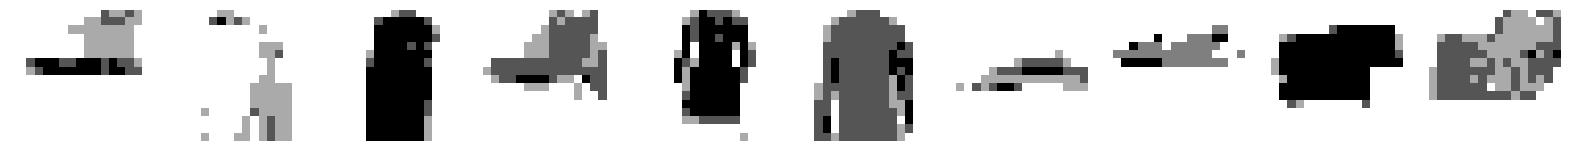

469/469 [==============================] - 29s 60ms/step - loss: 0.3273
Epoch 102/150
468/469 [============================>.] - ETA: 0s - loss: 0.3272  
Saved to ./output/generated_img_101.png


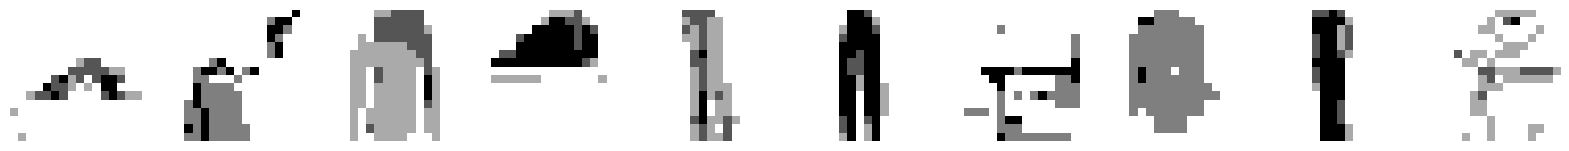

469/469 [==============================] - 28s 60ms/step - loss: 0.3272
Epoch 103/150
468/469 [============================>.] - ETA: 0s - loss: 0.3271  
Saved to ./output/generated_img_102.png


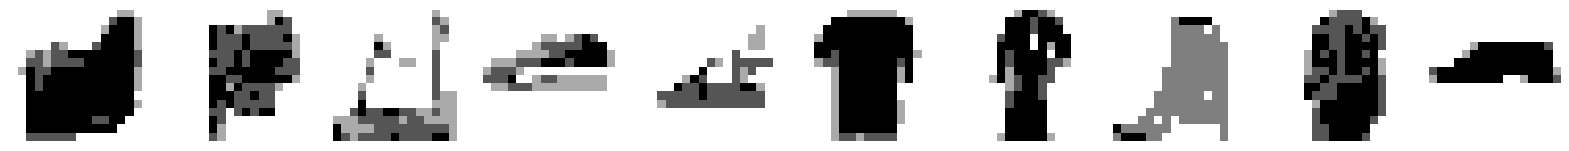

469/469 [==============================] - 29s 61ms/step - loss: 0.3271
Epoch 104/150
468/469 [============================>.] - ETA: 0s - loss: 0.3271  
Saved to ./output/generated_img_103.png


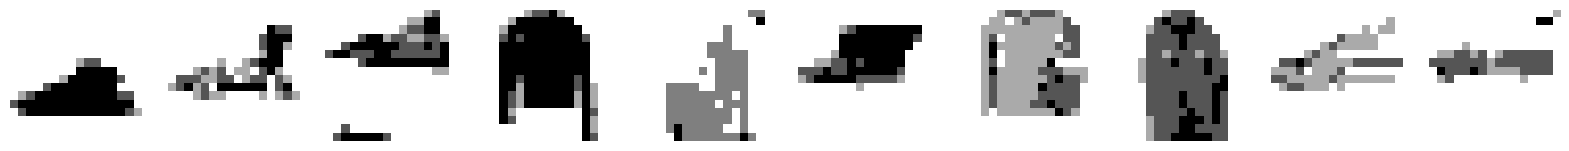

469/469 [==============================] - 29s 61ms/step - loss: 0.3271
Epoch 105/150
468/469 [============================>.] - ETA: 0s - loss: 0.3270  
Saved to ./output/generated_img_104.png


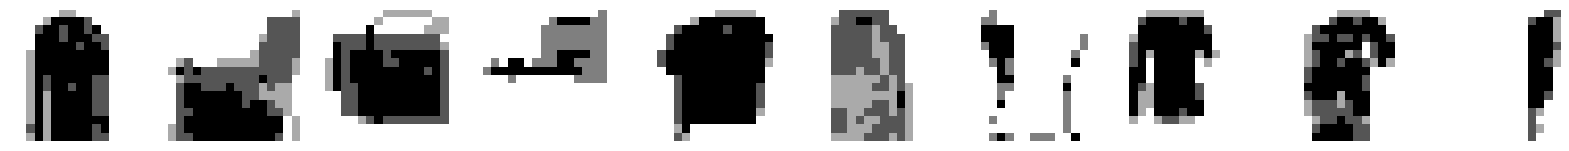

469/469 [==============================] - 28s 60ms/step - loss: 0.3270
Epoch 106/150
468/469 [============================>.] - ETA: 0s - loss: 0.3268  
Saved to ./output/generated_img_105.png


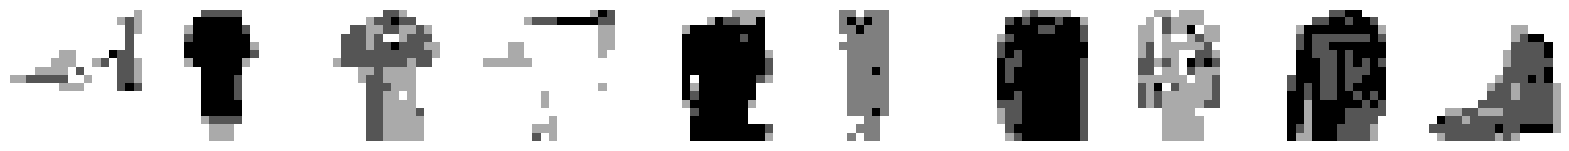

469/469 [==============================] - 29s 61ms/step - loss: 0.3268
Epoch 107/150
469/469 [==============================] - ETA: 0s - loss: 0.3267  
Saved to ./output/generated_img_106.png


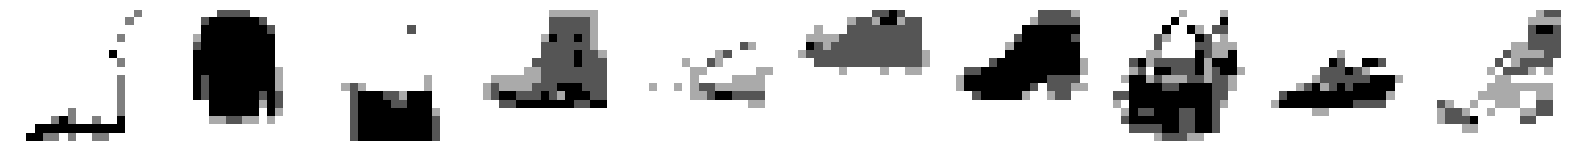

469/469 [==============================] - 29s 61ms/step - loss: 0.3267
Epoch 108/150
468/469 [============================>.] - ETA: 0s - loss: 0.3268  
Saved to ./output/generated_img_107.png


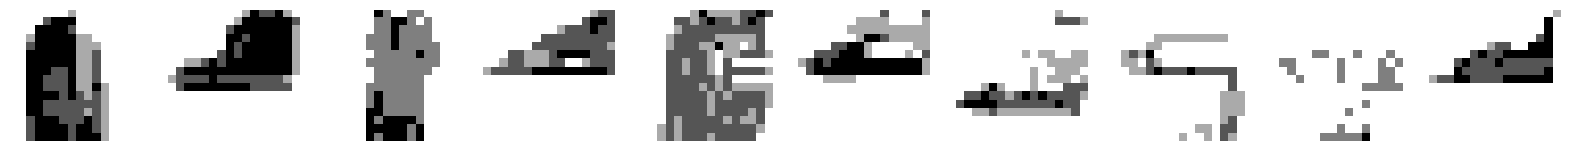

469/469 [==============================] - 29s 61ms/step - loss: 0.3268
Epoch 109/150
469/469 [==============================] - ETA: 0s - loss: 0.3264  
Saved to ./output/generated_img_108.png


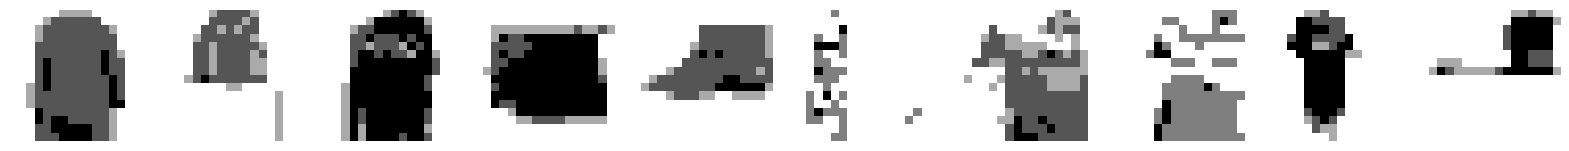

469/469 [==============================] - 29s 61ms/step - loss: 0.3264
Epoch 110/150
469/469 [==============================] - ETA: 0s - loss: 0.3264  
Saved to ./output/generated_img_109.png


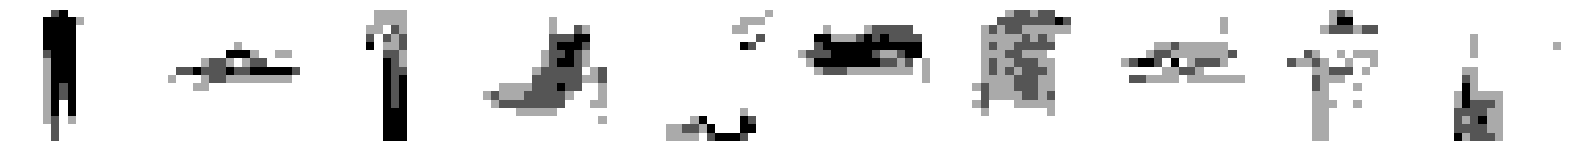

469/469 [==============================] - 29s 61ms/step - loss: 0.3264
Epoch 111/150
469/469 [==============================] - ETA: 0s - loss: 0.3265  
Saved to ./output/generated_img_110.png


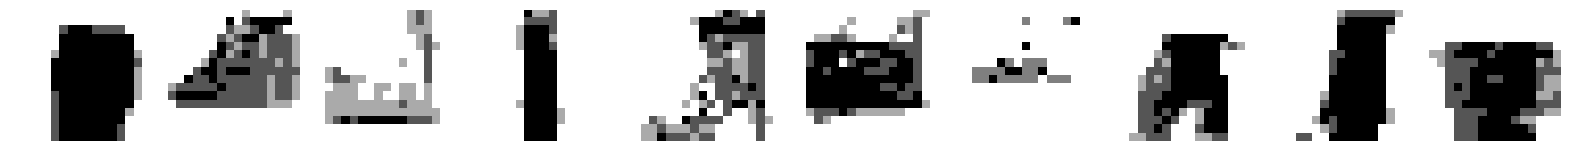

469/469 [==============================] - 28s 60ms/step - loss: 0.3265
Epoch 112/150
468/469 [============================>.] - ETA: 0s - loss: 0.3263  
Saved to ./output/generated_img_111.png


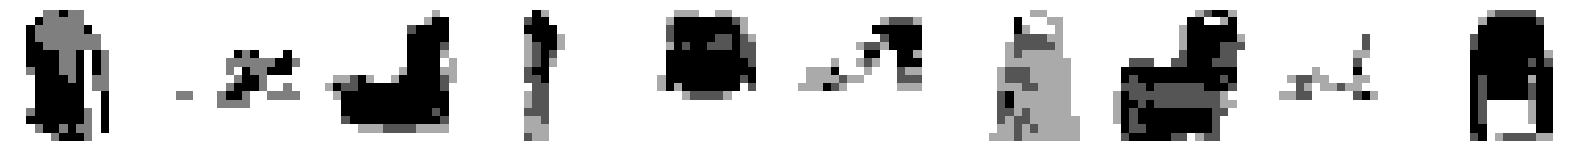

469/469 [==============================] - 29s 61ms/step - loss: 0.3263
Epoch 113/150
468/469 [============================>.] - ETA: 0s - loss: 0.3262  
Saved to ./output/generated_img_112.png


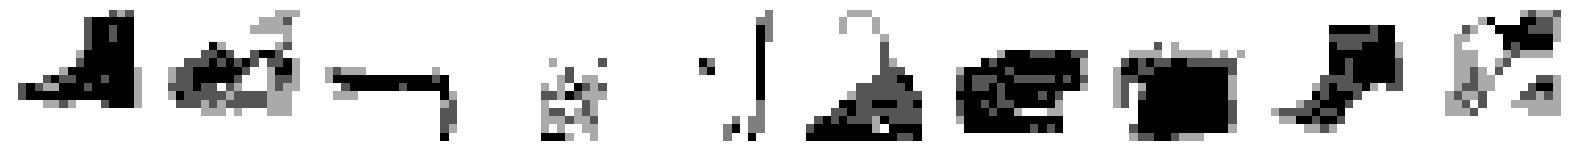

469/469 [==============================] - 28s 60ms/step - loss: 0.3262
Epoch 114/150
469/469 [==============================] - ETA: 0s - loss: 0.3261  
Saved to ./output/generated_img_113.png


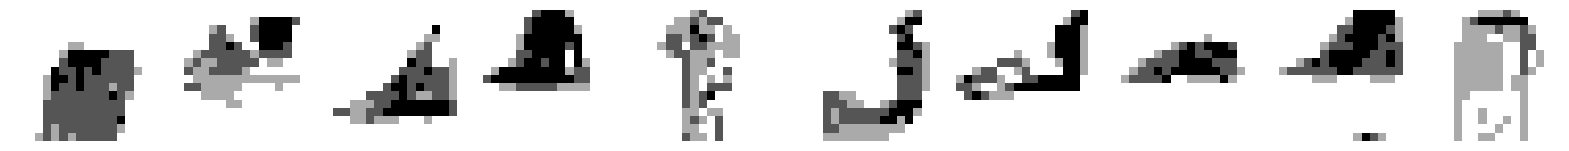

469/469 [==============================] - 29s 61ms/step - loss: 0.3261
Epoch 115/150
469/469 [==============================] - ETA: 0s - loss: 0.3259  
Saved to ./output/generated_img_114.png


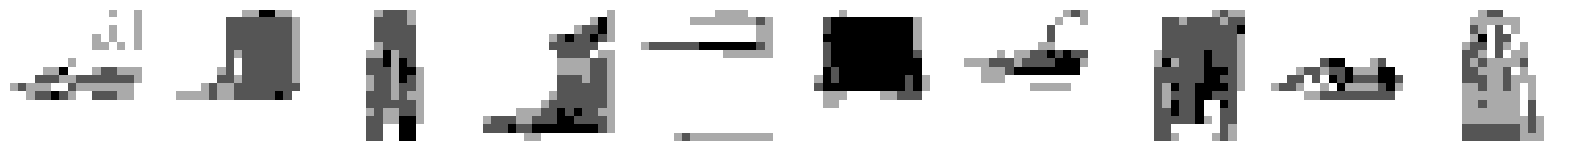

469/469 [==============================] - 29s 60ms/step - loss: 0.3259
Epoch 116/150
468/469 [============================>.] - ETA: 0s - loss: 0.3262  
Saved to ./output/generated_img_115.png


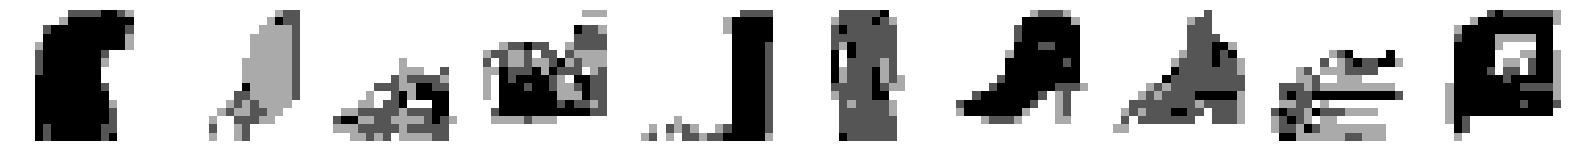

469/469 [==============================] - 29s 60ms/step - loss: 0.3261
Epoch 117/150
468/469 [============================>.] - ETA: 0s - loss: 0.3259  
Saved to ./output/generated_img_116.png


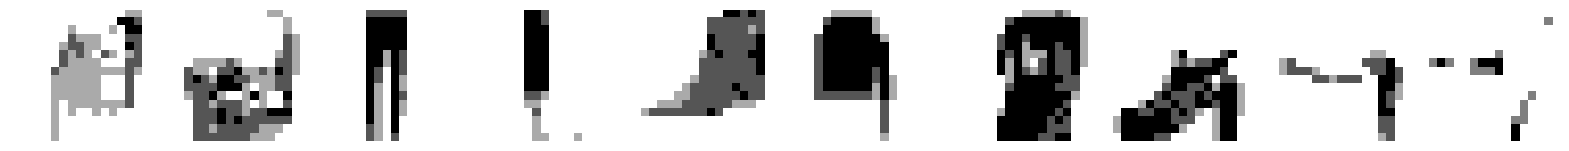

469/469 [==============================] - 29s 61ms/step - loss: 0.3259
Epoch 118/150
468/469 [============================>.] - ETA: 0s - loss: 0.3257  
Saved to ./output/generated_img_117.png


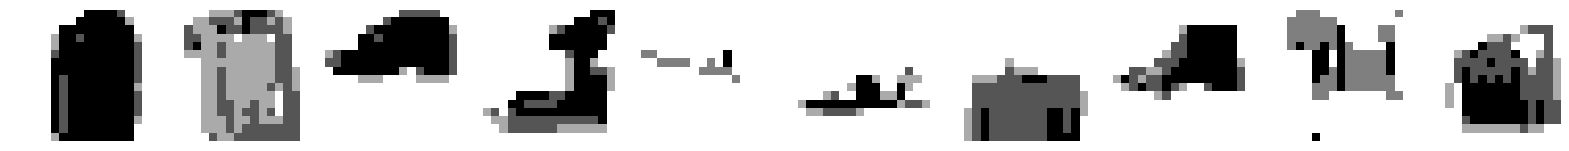

469/469 [==============================] - 29s 60ms/step - loss: 0.3257
Epoch 119/150
469/469 [==============================] - ETA: 0s - loss: 0.3256  
Saved to ./output/generated_img_118.png


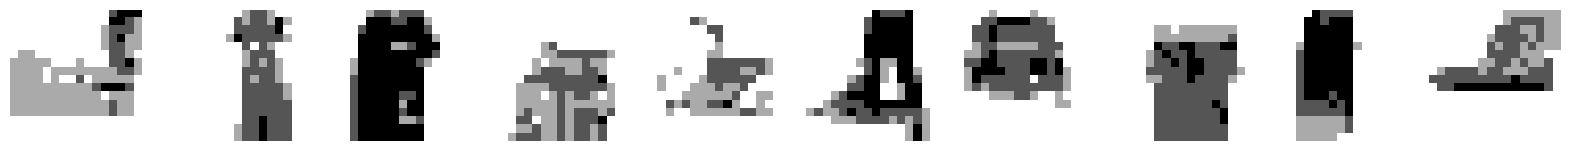

469/469 [==============================] - 29s 62ms/step - loss: 0.3256
Epoch 120/150
469/469 [==============================] - ETA: 0s - loss: 0.3258  
Saved to ./output/generated_img_119.png


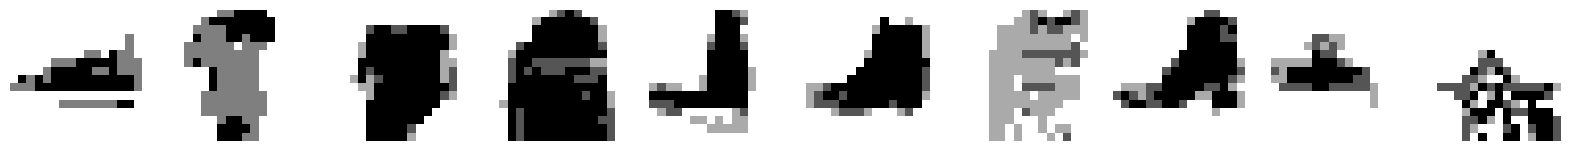

469/469 [==============================] - 29s 61ms/step - loss: 0.3258
Epoch 121/150
469/469 [==============================] - ETA: 0s - loss: 0.3254  
Saved to ./output/generated_img_120.png


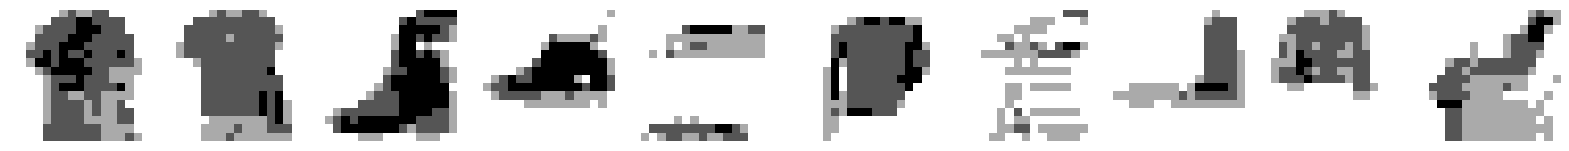

469/469 [==============================] - 29s 61ms/step - loss: 0.3254
Epoch 122/150
468/469 [============================>.] - ETA: 0s - loss: 0.3255  
Saved to ./output/generated_img_121.png


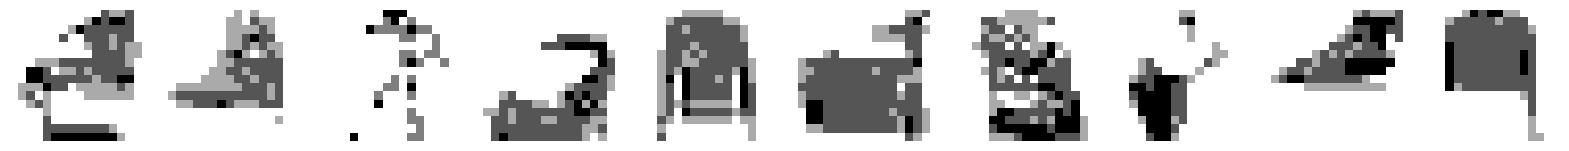

469/469 [==============================] - 29s 61ms/step - loss: 0.3255
Epoch 123/150
469/469 [==============================] - ETA: 0s - loss: 0.3254  
Saved to ./output/generated_img_122.png


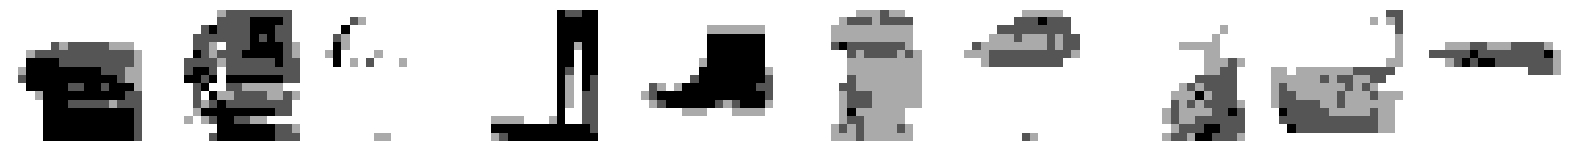

469/469 [==============================] - 29s 61ms/step - loss: 0.3254
Epoch 124/150
469/469 [==============================] - ETA: 0s - loss: 0.3252  
Saved to ./output/generated_img_123.png


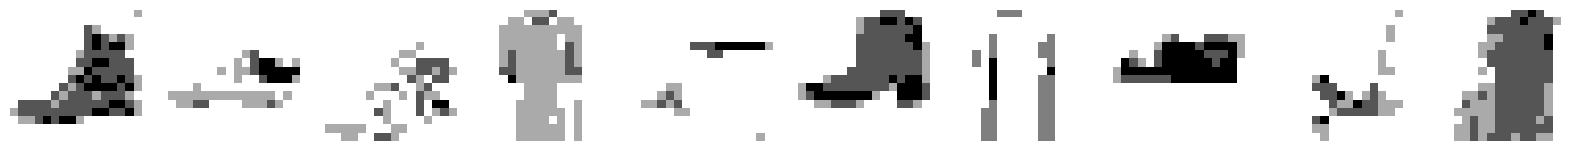

469/469 [==============================] - 29s 61ms/step - loss: 0.3252
Epoch 125/150
468/469 [============================>.] - ETA: 0s - loss: 0.3253  
Saved to ./output/generated_img_124.png


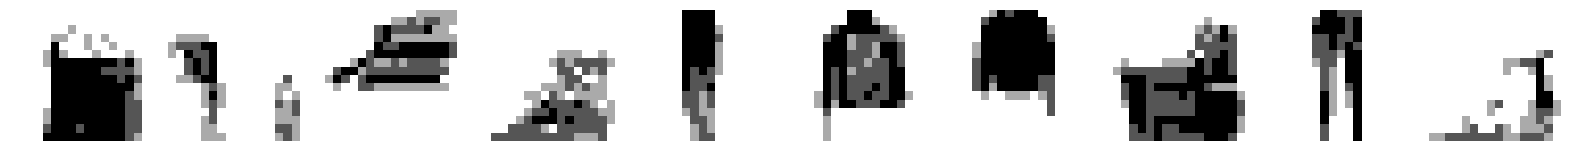

469/469 [==============================] - 32s 68ms/step - loss: 0.3253
Epoch 126/150
469/469 [==============================] - ETA: 0s - loss: 0.3253  
Saved to ./output/generated_img_125.png


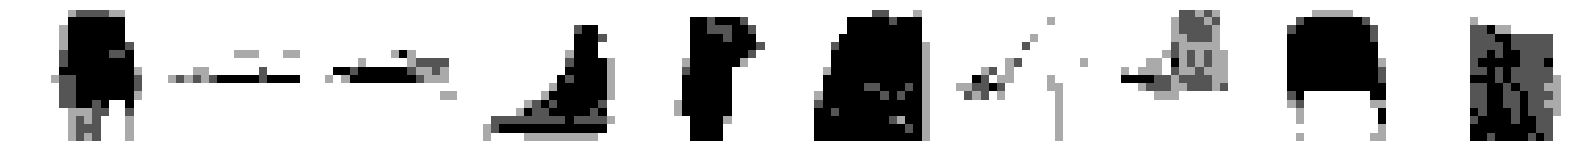

469/469 [==============================] - 31s 65ms/step - loss: 0.3253
Epoch 127/150
469/469 [==============================] - ETA: 0s - loss: 0.3251  
Saved to ./output/generated_img_126.png


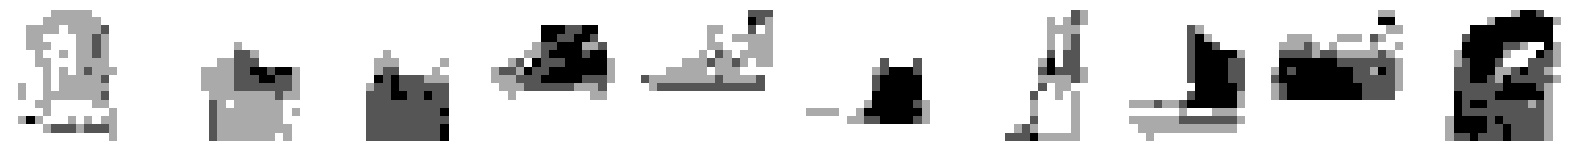

469/469 [==============================] - 31s 65ms/step - loss: 0.3251
Epoch 128/150
469/469 [==============================] - ETA: 0s - loss: 0.3250  
Saved to ./output/generated_img_127.png


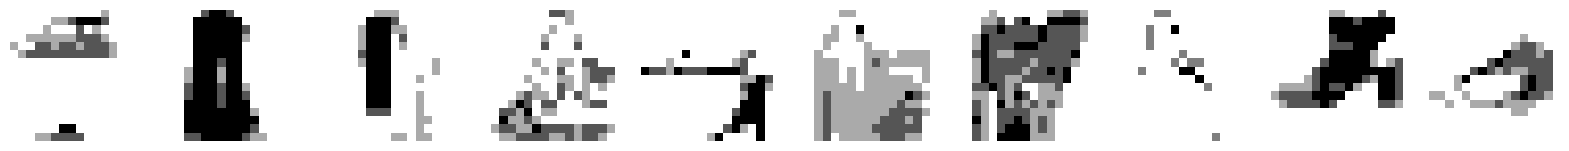

469/469 [==============================] - 31s 65ms/step - loss: 0.3250
Epoch 129/150
469/469 [==============================] - ETA: 0s - loss: 0.3249  
Saved to ./output/generated_img_128.png


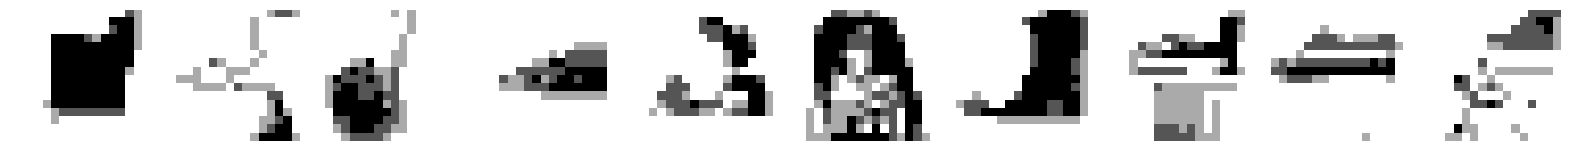

469/469 [==============================] - 31s 66ms/step - loss: 0.3249
Epoch 130/150
468/469 [============================>.] - ETA: 0s - loss: 0.3248  
Saved to ./output/generated_img_129.png


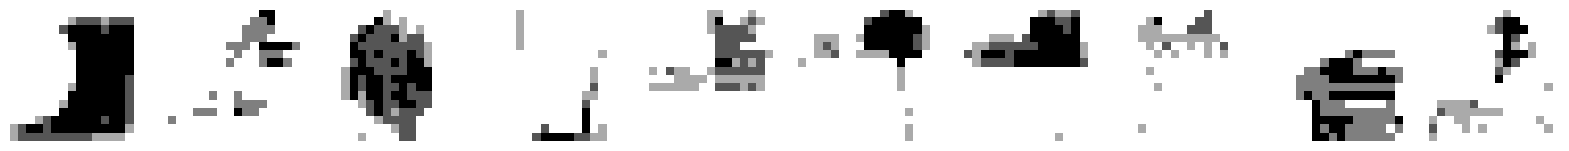

469/469 [==============================] - 31s 66ms/step - loss: 0.3248
Epoch 131/150
469/469 [==============================] - ETA: 0s - loss: 0.3249  
Saved to ./output/generated_img_130.png


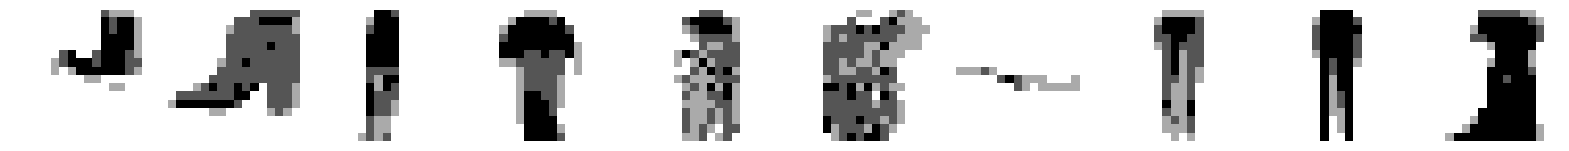

469/469 [==============================] - 31s 65ms/step - loss: 0.3249
Epoch 132/150
469/469 [==============================] - ETA: 0s - loss: 0.3246  
Saved to ./output/generated_img_131.png


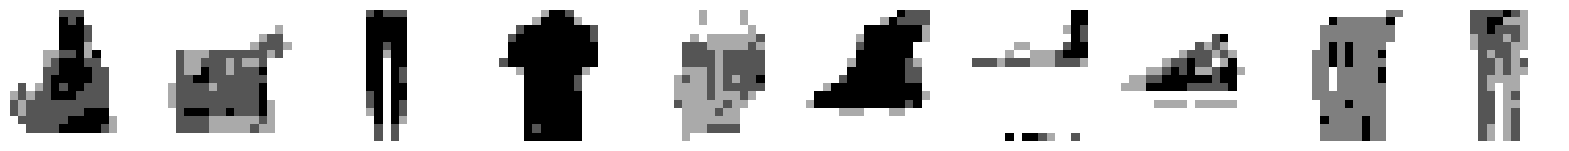

469/469 [==============================] - 31s 65ms/step - loss: 0.3246
Epoch 133/150
468/469 [============================>.] - ETA: 0s - loss: 0.3247  
Saved to ./output/generated_img_132.png


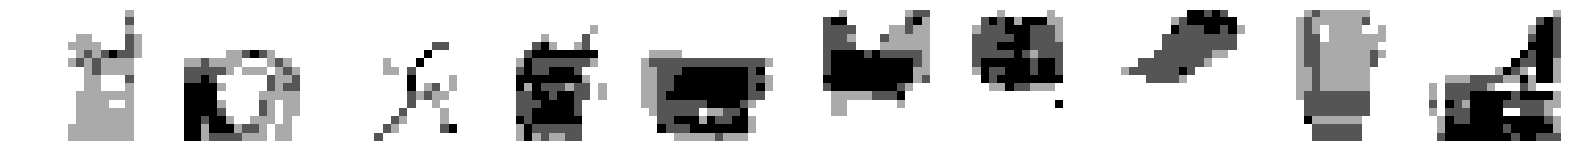

469/469 [==============================] - 31s 66ms/step - loss: 0.3247
Epoch 134/150
468/469 [============================>.] - ETA: 0s - loss: 0.3246  
Saved to ./output/generated_img_133.png


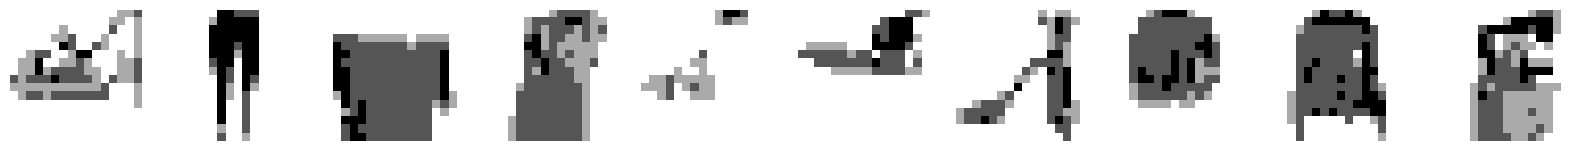

469/469 [==============================] - 31s 66ms/step - loss: 0.3247
Epoch 135/150
468/469 [============================>.] - ETA: 0s - loss: 0.3245  
Saved to ./output/generated_img_134.png


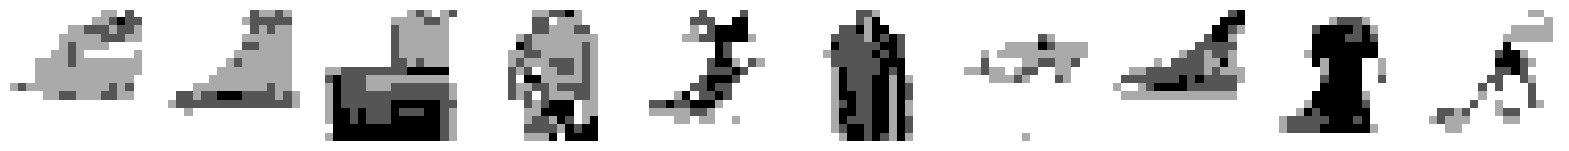

469/469 [==============================] - 31s 66ms/step - loss: 0.3245
Epoch 136/150
469/469 [==============================] - ETA: 0s - loss: 0.3245  
Saved to ./output/generated_img_135.png


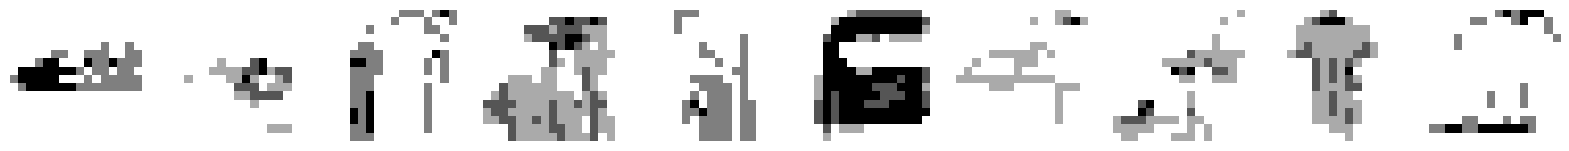

469/469 [==============================] - 31s 65ms/step - loss: 0.3245
Epoch 137/150
468/469 [============================>.] - ETA: 0s - loss: 0.3244  
Saved to ./output/generated_img_136.png


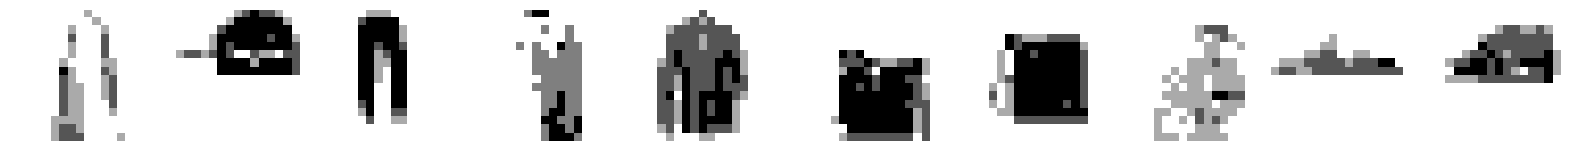

469/469 [==============================] - 31s 65ms/step - loss: 0.3244
Epoch 138/150
469/469 [==============================] - ETA: 0s - loss: 0.3243  
Saved to ./output/generated_img_137.png


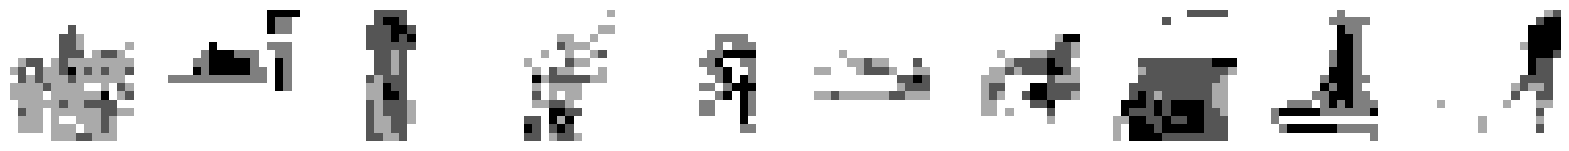

469/469 [==============================] - 29s 61ms/step - loss: 0.3243
Epoch 139/150
468/469 [============================>.] - ETA: 0s - loss: 0.3244  
Saved to ./output/generated_img_138.png


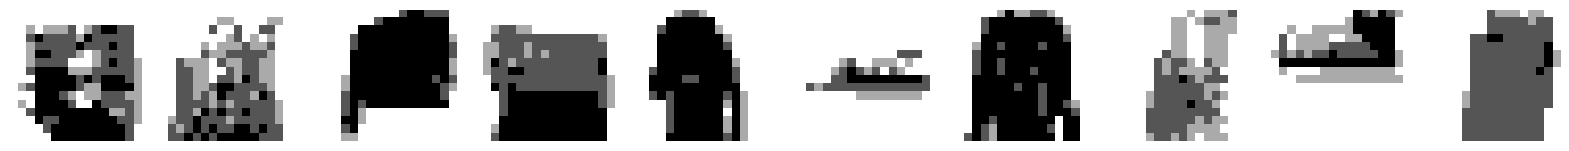

469/469 [==============================] - 29s 61ms/step - loss: 0.3244
Epoch 140/150
469/469 [==============================] - ETA: 0s - loss: 0.3242  
Saved to ./output/generated_img_139.png


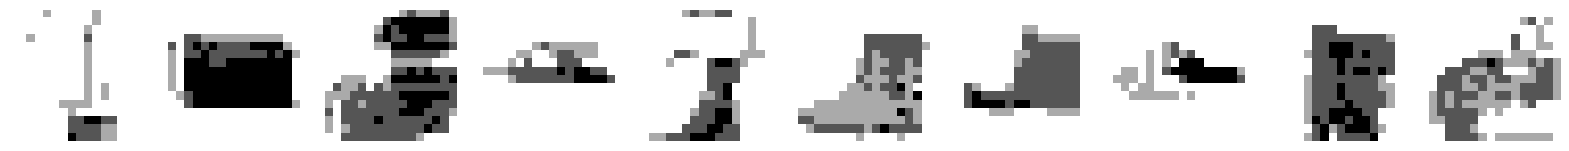

469/469 [==============================] - 29s 61ms/step - loss: 0.3242
Epoch 141/150
469/469 [==============================] - ETA: 0s - loss: 0.3241  
Saved to ./output/generated_img_140.png


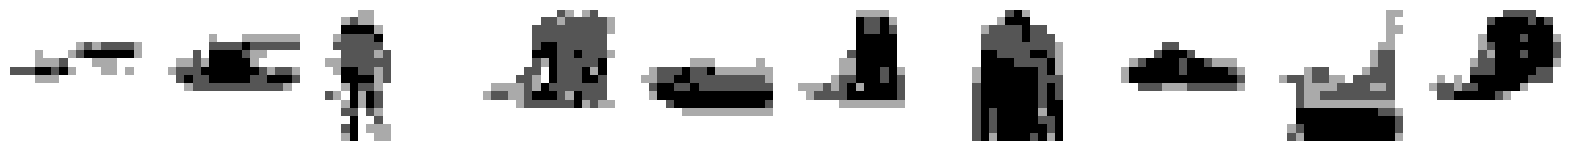

469/469 [==============================] - 29s 62ms/step - loss: 0.3241
Epoch 142/150
468/469 [============================>.] - ETA: 0s - loss: 0.3240  
Saved to ./output/generated_img_141.png


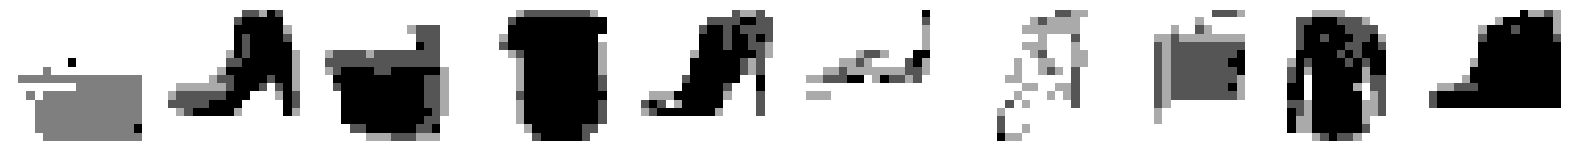

469/469 [==============================] - 29s 61ms/step - loss: 0.3240
Epoch 143/150
468/469 [============================>.] - ETA: 0s - loss: 0.3241  
Saved to ./output/generated_img_142.png


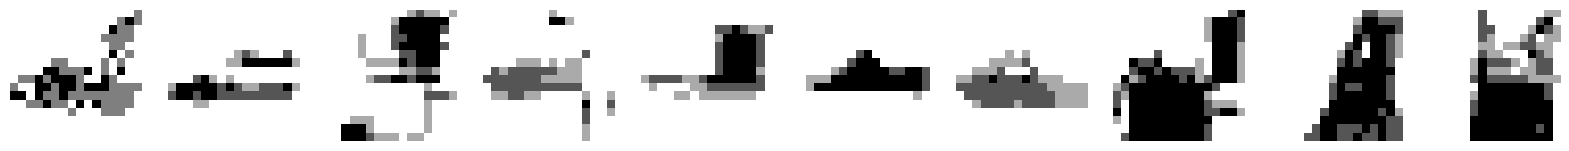

469/469 [==============================] - 29s 61ms/step - loss: 0.3241
Epoch 144/150
468/469 [============================>.] - ETA: 0s - loss: 0.3239  
Saved to ./output/generated_img_143.png


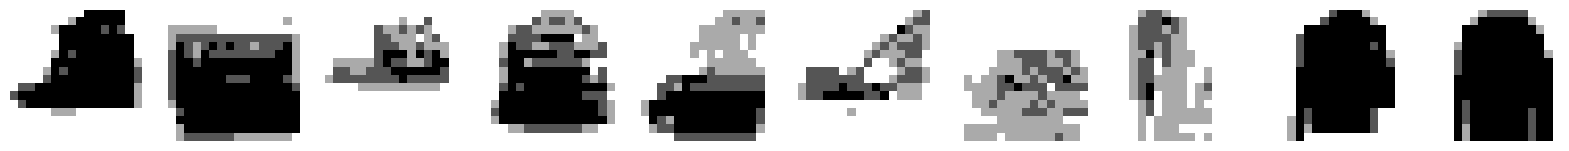

469/469 [==============================] - 29s 62ms/step - loss: 0.3240
Epoch 145/150
469/469 [==============================] - ETA: 0s - loss: 0.3239  
Saved to ./output/generated_img_144.png


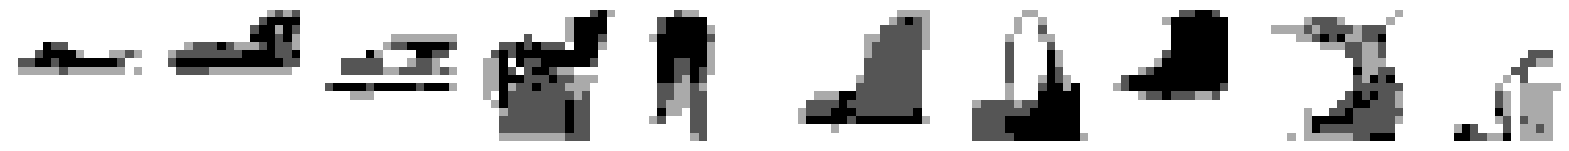

469/469 [==============================] - 29s 61ms/step - loss: 0.3239
Epoch 146/150
468/469 [============================>.] - ETA: 0s - loss: 0.3240  
Saved to ./output/generated_img_145.png


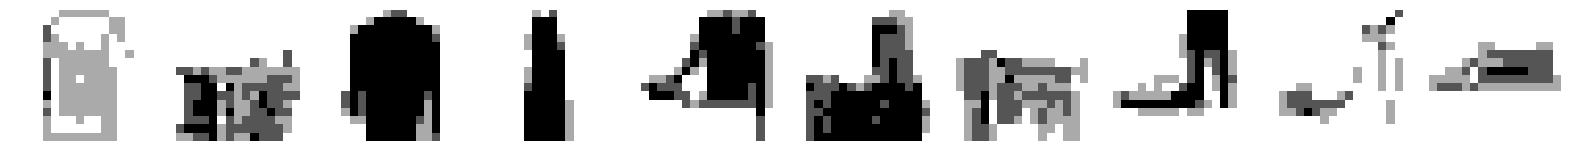

469/469 [==============================] - 29s 61ms/step - loss: 0.3240
Epoch 147/150
469/469 [==============================] - ETA: 0s - loss: 0.3237  
Saved to ./output/generated_img_146.png


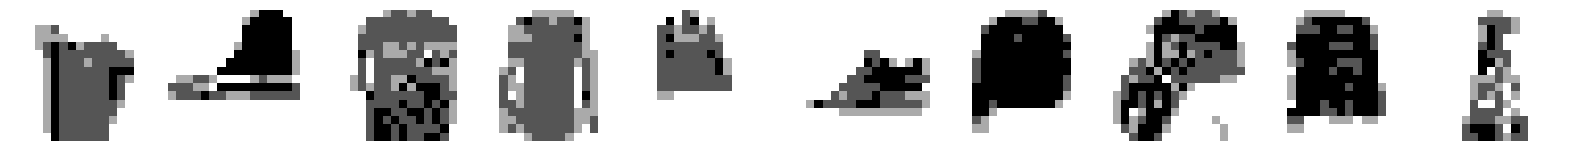

469/469 [==============================] - 29s 61ms/step - loss: 0.3237
Epoch 148/150
468/469 [============================>.] - ETA: 0s - loss: 0.3236  
Saved to ./output/generated_img_147.png


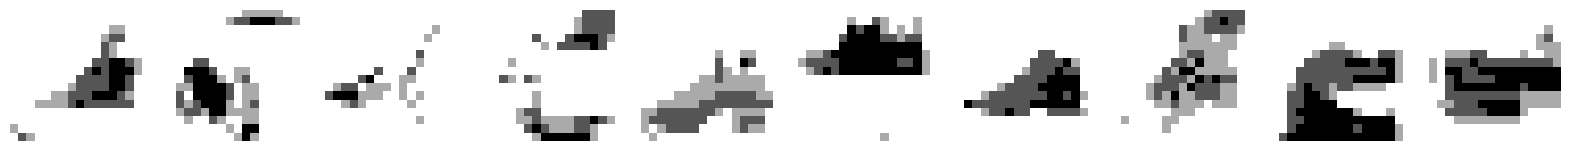

469/469 [==============================] - 29s 60ms/step - loss: 0.3236
Epoch 149/150
469/469 [==============================] - ETA: 0s - loss: 0.3236  
Saved to ./output/generated_img_148.png


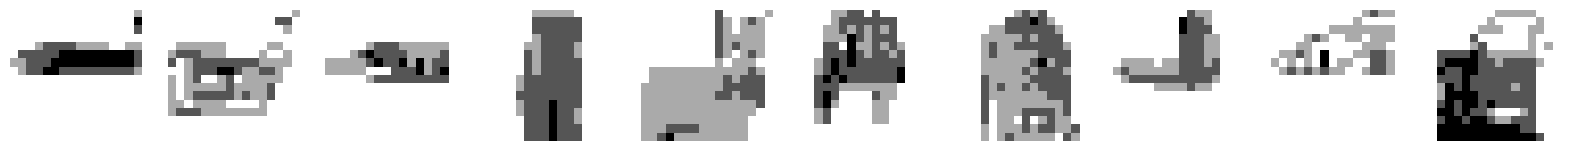

469/469 [==============================] - 29s 60ms/step - loss: 0.3236
Epoch 150/150
468/469 [============================>.] - ETA: 0s - loss: 0.3235  
Saved to ./output/generated_img_149.png


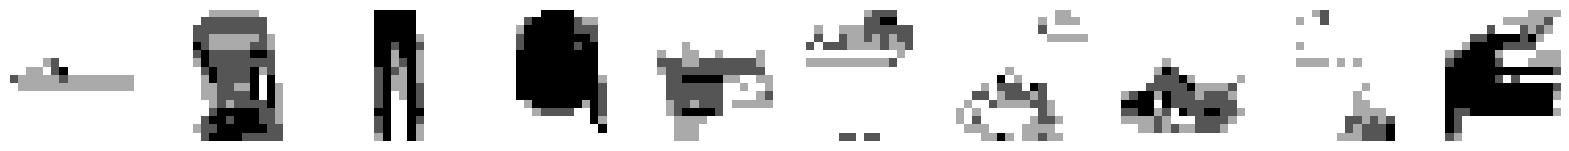

469/469 [==============================] - 28s 60ms/step - loss: 0.3235


In [11]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. Generate images <a name="generate"></a>

In [12]:
generated_images = img_generator_callback.generate(temperature=1.0)

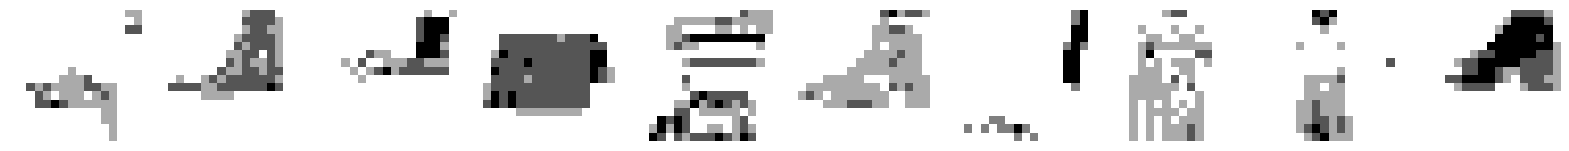

In [13]:
display(generated_images)